In [1]:
import ROOT as rt

import array as arr
import math

from strangehelper import get_parabola, make_mixed_corrections

Welcome to JupyROOT 6.24/06


In [2]:
rt.gStyle.SetOptStat(0)

In [3]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [4]:
# decide whether to do sideband subtraction or not
DO_SIDEBAND_SUBTRACTION = True

In [5]:
# UE line method
USE_AVG = 1
USE_ZYAM = 0
USE_NONEG = 0
assert sum([USE_AVG, USE_ZYAM, USE_NONEG]) == 1, "Only select 1 method for UE line please"

In [6]:
# ETA CUTS 
ETA_MIN = -0.8
ETA_MAX = 0.8 - EPSILON
DELTA_ETA_MIN = -1.4
DELTA_ETA_MAX = 1.4 - EPSILON

In [7]:
# PT CUTS
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8 - EPSILON
ASSOC_PT_LOW = 2 
ASSOC_PT_HIGH = 4 - EPSILON

In [8]:
# SIGNAL AND SIDEBAND REGION CUTS
SIG_MIN = 1.10 
SIG_MAX = 1.14 - EPSILON

RSB_MIN_0_20 = 1.16
RSB_MAX_0_20 = 1.18 - EPSILON
RSB_MIN_20_50 = 1.16
RSB_MAX_20_50 = 1.18 - EPSILON
RSB_MIN_50_80 = 1.16
RSB_MAX_50_80 = 1.18 - EPSILON

In [9]:
c = rt.TCanvas("main_canvas", "Main Canvas", 55, 55, 800, 600)
c.SetRightMargin(0.05)
c.SetLeftMargin(0.15)
c.SetTopMargin(0.05)

# 0-20 setup

In [10]:
input_file_0_20 = rt.TFile("../online/res/res_correct_eff_cent_0_20.root")
input_list_0_20 = input_file_0_20.Get("h-lambda")
input_file_0_20.Close()

In [11]:
trig_dist_0_20 = input_list_0_20.FindObject("fTriggerDist")
lambda_dist_0_20 = input_list_0_20.FindObject("fTriggeredLambdaDist")
lambda_ls_dist_0_20 = input_list_0_20.FindObject("fTriggeredLambdaLSDist")

In [12]:
trig_dist_0_20_highest_pt = input_list_0_20.FindObject("fTriggerDist_highestPt")

In [13]:
h_h_0_20 = input_list_0_20.FindObject("fDphiHH")
h_h_mixed_0_20 = input_list_0_20.FindObject("fDphiHHMixed")

In [14]:
h_h_0_20_highest_pt = input_list_0_20.FindObject("fDphiHH_highestPt")
h_h_mixed_0_20_highest_pt = input_list_0_20.FindObject("fDphiHHMixed_highestPt")

In [15]:
h_lambda_0_20 = input_list_0_20.FindObject("fDphiHLambda")
h_lambda_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaMixed")

In [16]:
h_lambda_mixed_0_20_highest_pt = input_list_0_20.FindObject("fDphiHLambdaMixed_highestPt")
h_lambda_0_20_highest_pt = input_list_0_20.FindObject("fDphiHLambda_highestPt")

In [17]:
# Setting the trigger Pt (this is never changed again)
trig_dist_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
trig_dist_0_20_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [18]:
# Setting the associated Pt (this is never changed again)
lambda_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
lambda_ls_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [19]:
# Setting the eta cuts for single particle dists
trig_dist_0_20.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
trig_dist_0_20_highest_pt.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
lambda_dist_0_20.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)
lambda_ls_dist_0_20.GetAxis(2).SetRangeUser(ETA_MIN, ETA_MAX)

In [20]:
trig_pt_dist_0_20 = trig_dist_0_20.Projection(0).Clone("trig_pt_dist_0_20")
trig_phi_dist_0_20 = trig_dist_0_20.Projection(1).Clone("trig_phi_dist_0_20")
trig_eta_dist_0_20 = trig_dist_0_20.Projection(2).Clone("trig_eta_dist_0_20")
trig_2d_dist_0_20 = trig_dist_0_20.Projection(0, 3).Clone("trig_2d_dist_0_20")

trig_pt_dist_0_20.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_0_20.Sumw2()
trig_pt_dist_0_20.SetLineColor(rt.kRed)

trig_phi_dist_0_20.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_0_20.Sumw2()
trig_phi_dist_0_20.SetLineColor(rt.kRed)

trig_eta_dist_0_20.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_0_20.Sumw2()
trig_eta_dist_0_20.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [21]:
trig_pt_dist_0_20_highest_pt = trig_dist_0_20_highest_pt.Projection(0).Clone("trig_pt_dist_0_20_highest_pt")
trig_phi_dist_0_20_highest_pt = trig_dist_0_20_highest_pt.Projection(1).Clone("trig_phi_dist_0_20_highest_pt")
trig_eta_dist_0_20_highest_pt = trig_dist_0_20_highest_pt.Projection(2).Clone("trig_eta_dist_0_20_highest_pt")
trig_2d_dist_0_20_highest_pt = trig_dist_0_20_highest_pt.Projection(0, 3).Clone("trig_2d_dist_0_20_highest_pt")

trig_pt_dist_0_20_highest_pt.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_0_20_highest_pt.Sumw2()
trig_pt_dist_0_20_highest_pt.SetLineColor(rt.kRed)

trig_phi_dist_0_20_highest_pt.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_0_20_highest_pt.Sumw2()
trig_phi_dist_0_20_highest_pt.SetLineColor(rt.kRed)

trig_eta_dist_0_20_highest_pt.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_0_20_highest_pt.Sumw2()
trig_eta_dist_0_20_highest_pt.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [22]:
num_trigs_0_20 = trig_2d_dist_0_20.Integral()
num_trigs_0_20_highest_pt = trig_2d_dist_0_20_highest_pt.Integral()

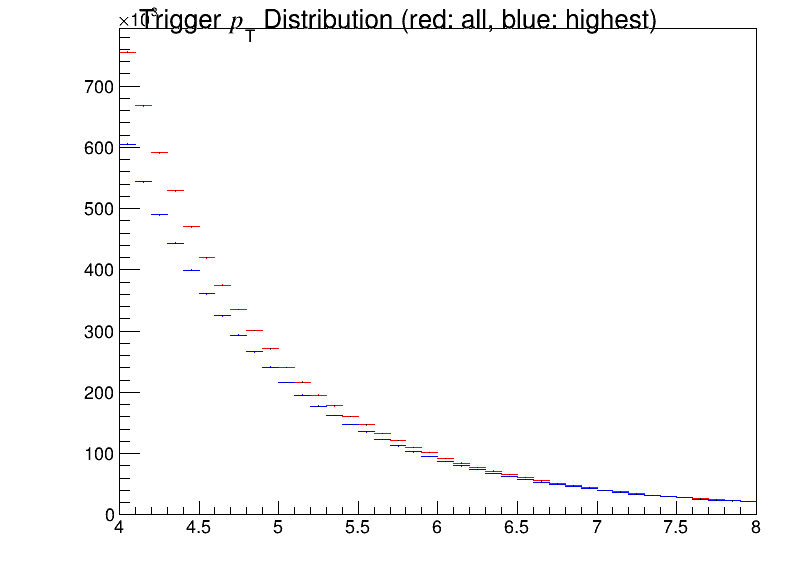

In [23]:
trig_pt_dist_0_20.Draw()
trig_pt_dist_0_20_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_0_20_highest_pt.Draw("SAME")
c.Draw()

In [24]:
trig_pt_dist_0_20.Scale(1/num_trigs_0_20)
trig_pt_dist_0_20_highest_pt.Scale(1/num_trigs_0_20_highest_pt)

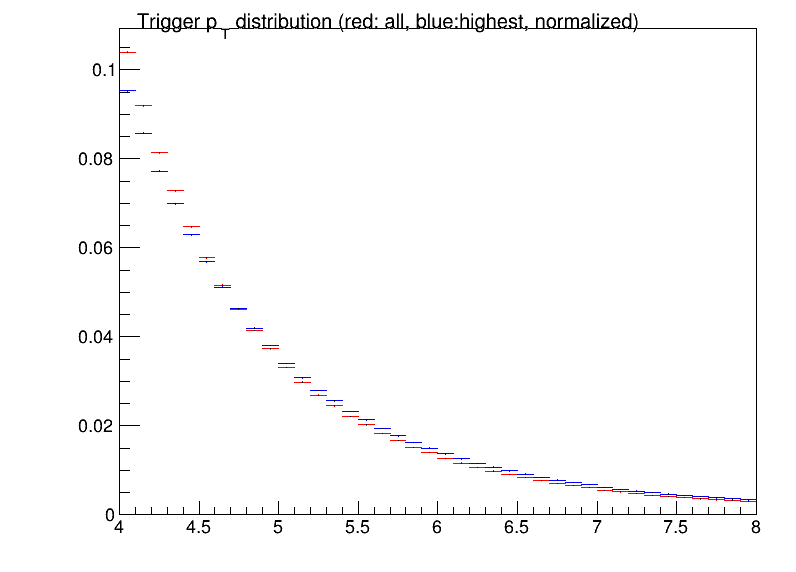

In [25]:
trig_pt_dist_0_20.SetTitle("Trigger p_{T} distribution (red: all, blue:highest, normalized)")
trig_pt_dist_0_20.Draw()
trig_pt_dist_0_20_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_0_20_highest_pt.Draw("SAME")
c.Draw()

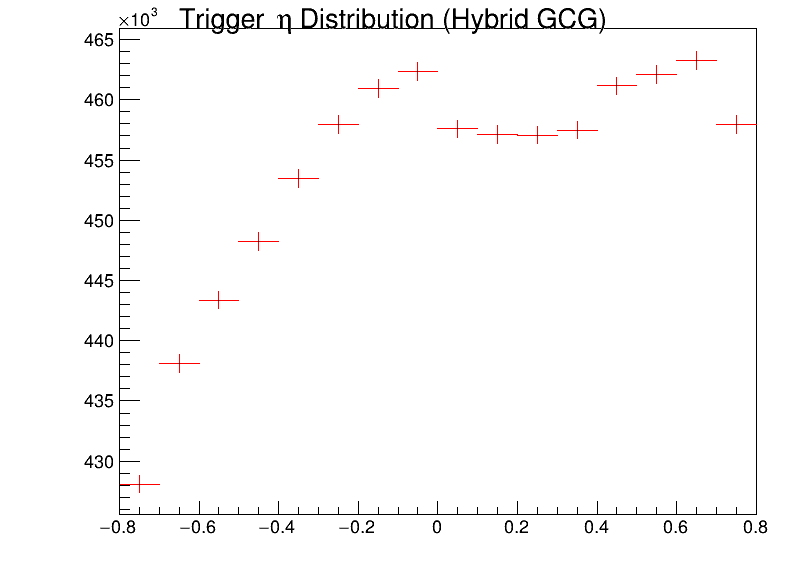

In [26]:
trig_eta_dist_0_20.Draw()
c.Draw()

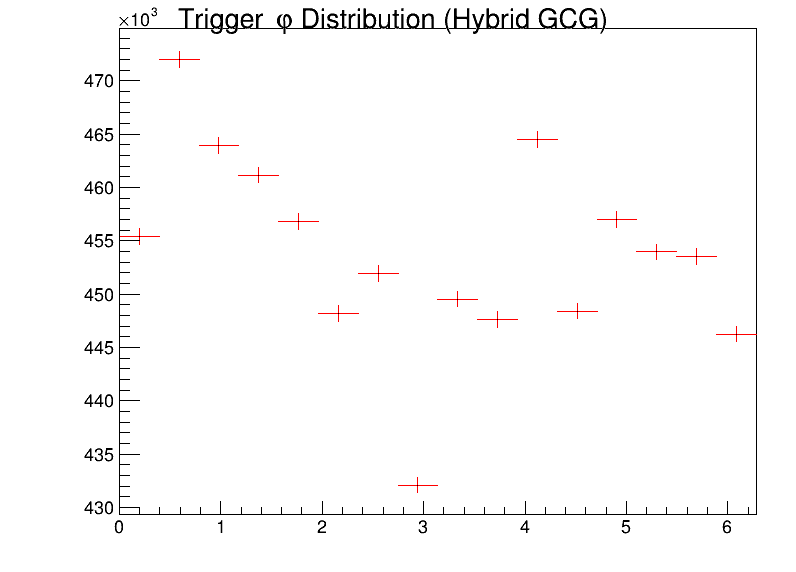

In [27]:
trig_phi_dist_0_20.Draw()
c.Draw()

### Signal analysis section

In [28]:
lambda_mass_dist_0_20 = lambda_dist_0_20.Projection(3).Clone("lambda_mass_dist_0_20")
lambda_mass_ls_dist_0_20 = lambda_ls_dist_0_20.Projection(3).Clone("lambda_mass_ls_dist_0_20")

In [29]:
# scale LS to match lambda dist in RSB
left_bin = lambda_mass_dist_0_20.FindBin(RSB_MIN_0_20)
right_bin = lambda_mass_dist_0_20.FindBin(RSB_MAX_0_20)
lambda_mass_ls_dist_0_20.Scale(lambda_mass_dist_0_20.Integral(left_bin, right_bin)/lambda_mass_ls_dist_0_20.Integral(left_bin, right_bin))

In [30]:
lambda_mass_dist_0_20.SetTitle("")
lambda_mass_dist_0_20.Sumw2()
lambda_mass_dist_0_20.SetLineWidth(2)
lambda_mass_dist_0_20.SetLineColor(rt.kBlack)
lambda_mass_dist_0_20.SetMarkerStyle(20)
lambda_mass_dist_0_20.SetMarkerSize(0.5)
lambda_mass_dist_0_20.SetMarkerColor(rt.kBlack)
lambda_mass_dist_0_20.GetXaxis().SetTitle("M_{p#pi} (GeV/c^{2})")
lambda_mass_dist_0_20.GetYaxis().SetTitle("Counts/[10 MeV/c^{2}]")

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [31]:
lambda_mass_ls_dist_0_20.SetLineWidth(2)
lambda_mass_ls_dist_0_20.SetLineColor(rt.kViolet - 6)
lambda_mass_ls_dist_0_20.SetMarkerStyle(20)
lambda_mass_ls_dist_0_20.SetMarkerSize(0.5)
lambda_mass_ls_dist_0_20.SetMarkerColor(rt.kViolet - 6)

In [32]:
residual_0_20 = lambda_mass_dist_0_20.Clone("residual_0_20")
residual_0_20.Add(lambda_mass_ls_dist_0_20, -1)

residual_0_20.SetLineWidth(2)
residual_0_20.SetLineColor(rt.kGreen + 2)
residual_0_20.SetMarkerStyle(20)
residual_0_20.SetMarkerSize(0.5)
residual_0_20.SetMarkerColor(rt.kGreen + 2)

In [33]:
RSB_region_test = rt.TH1D("RSB_region_test", "", 100, RSB_MIN_0_20, RSB_MAX_0_20)
RSB_region_test.SetMarkerStyle(21)
RSB_region_test.SetMarkerSize(3)
RSB_region_test.SetMarkerColor(rt.kRed)
RSB_region_test.SetLineColor(rt.kRed)
RSB_region_test.SetFillColor(rt.kRed)
RSB_region_test.SetFillStyle(3001)


RSB_region = rt.TBox(RSB_MIN_0_20, 0, RSB_MAX_0_20, lambda_mass_dist_0_20.GetMaximum()*1.055)
RSB_region.SetLineColor(rt.kRed)
RSB_region.SetFillColor(rt.kRed)
RSB_region.SetFillStyle(3003)

In [34]:
mass_legend_0_20 = rt.TLegend(0.4, 0.2, 0.6, 0.4)
mass_legend_0_20.SetTextSize(0.02)
mass_legend_0_20.SetBorderSize(0)
mass_legend_0_20.SetFillStyle(0)
mass_legend_0_20.AddEntry(lambda_mass_dist_0_20, "Total (sig. + comb. BG)", "lp")
# mass_legend_0_20.AddEntry(lambda_mass_ls_dist_0_20, "Like-sign p-#pi BG scaled to Total in RSB", "lp")
# mass_legend_0_20.AddEntry(RSB_region, "RSB region: 1.20 < M_{p#pi} < 1.22", "f")

Info in <TCanvas::Print>: pdf file lambda_mass_0_20_resonance.pdf has been created


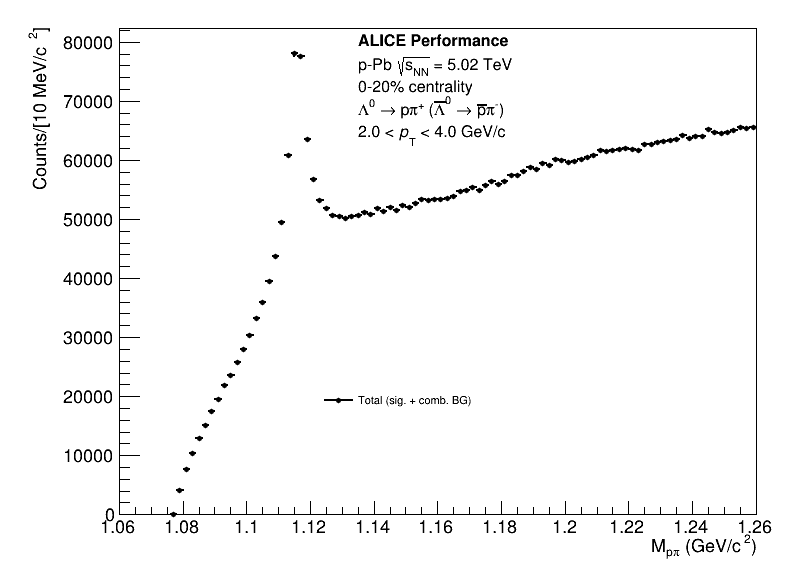

In [35]:
lambda_mass_dist_0_20.Draw()
# lambda_mass_ls_dist_0_20.Draw("SAME")
mass_legend_0_20.Draw("SAME")


alice_data_label = rt.TLatex()
alice_data_label.SetNDC()
alice_data_label.SetTextSize(0.03)
alice_data_label.SetTextAlign(13)
alice_data_label.DrawLatex(0.45, 0.94, "ALICE Performance")
alice_data_label.DrawLatex(0.45, 0.9, "#bf{p-Pb #sqrt{s_{NN}} = 5.02 TeV}")
alice_data_label.DrawLatex(0.45, 0.86, "#bf{0-20% centrality}")
alice_data_label.DrawLatex(0.45, 0.83, "#bf{#Lambda^{0} #rightarrow p#pi^{+} (#bar{#Lambda}^{0} #rightarrow #bar{p}#pi^{-})}")
alice_data_label.DrawLatex(0.45, 0.78, "#bf{2.0 < #it{p}_{T} < 4.0 GeV/c}")


# RSB_min_line = rt.TLine(RSB_MIN, 0, RSB_MIN, lambda_mass_dist_0_20.GetMaximum()*1.05)
# RSB_min_line.SetLineColor(rt.kRed)
# RSB_min_line.SetLineWidth(2)
# RSB_min_line.SetLineStyle(2)
# RSB_min_line.Draw("SAME")


# RSB_max_line = rt.TLine(RSB_MAX, 0, RSB_MAX, lambda_mass_dist_0_20.GetMaximum()*1.05)
# RSB_max_line.SetLineColor(rt.kRed)
# RSB_max_line.SetLineWidth(2)
# RSB_max_line.SetLineStyle(2)
# RSB_max_line.Draw("SAME")


# RSB_region.Draw()


c.Draw()
c.SaveAs("lambda_mass_0_20_resonance.pdf")

In [36]:
left_signal_bin_0_20 = lambda_mass_dist_0_20.FindBin(SIG_MIN)
right_signal_bin_0_20 = lambda_mass_dist_0_20.FindBin(SIG_MAX)

lambda_bg_0_20 = 0
lambda_total_0_20 = 0
for bin_num in range(left_signal_bin_0_20, right_signal_bin_0_20 + 1):
    lambda_total_0_20 += lambda_mass_dist_0_20.GetBinContent(bin_num)
    lambda_bg_0_20 += lambda_mass_ls_dist_0_20.GetBinContent(bin_num)

lambda_signal_0_20 = lambda_total_0_20 - lambda_bg_0_20
lambda_signal_total_ratio_0_20 = lambda_signal_0_20/lambda_total_0_20
lambda_signal_bg_ratio_0_20 = lambda_signal_0_20/lambda_bg_0_20
print(f"The 0-20 lambda signal is: {lambda_signal_0_20}")
print(f"The 0-20 lambda background is: {lambda_bg_0_20}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_0_20}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_0_20}")
print(f"The 0-20 lambda significance is: {lambda_signal_0_20/math.sqrt(lambda_signal_0_20 + lambda_bg_0_20)}")

The 0-20 lambda signal is: 321342.7524223963
The 0-20 lambda background is: 707465.7893041929
The 0-20 lambda S/B is: 0.45421666641781155
The 0-20 lambda S/T is: 0.3123445611008493
The 0-20 lambda significance is: 316.81171217035563


Extracted signal: 342168.8181291261


Warning in <TFile::Init>: file mc_templates.root probably not closed, trying to recover
Info in <TFile::Recover>: mc_templates.root, recovered key TH1D:lambda_mass_dist at address 230
Info in <TFile::Recover>: mc_templates.root, recovered key TH1D:lambda_mass_dist_nobg at address 3094
Warning in <TFile::Init>: successfully recovered 2 keys
Info in <TCanvas::Print>: pdf file figures/lambda_mass_0_20_resonance_signal_comp.pdf has been created


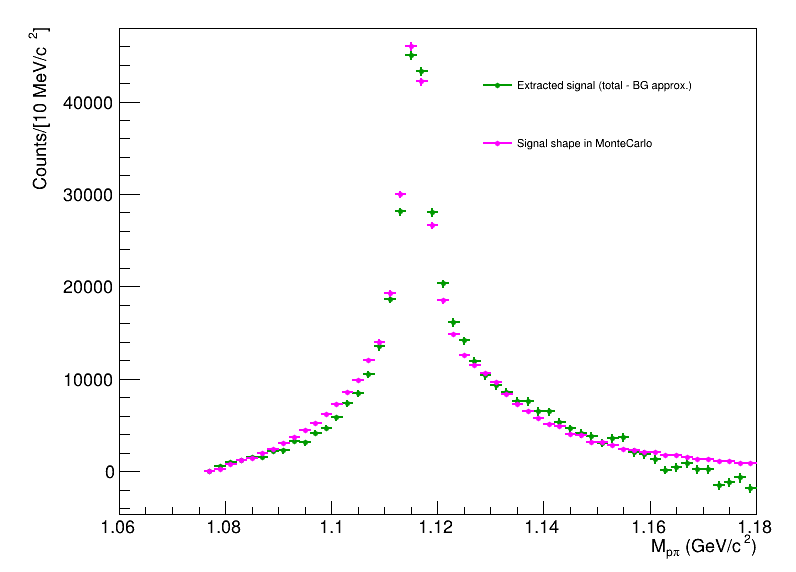

In [37]:

left_bin = residual_0_20.FindBin(SIG_MIN)
right_bin = residual_0_20.FindBin(SIG_MAX)

print(f"Extracted signal: {residual_0_20.Integral()}")
templates_file = rt.TFile("mc_templates.root", "READ")

lambda_mass_template = templates_file.Get("lambda_mass_dist_nobg")
lambda_mass_template.Rebin(2)
scale_factor_0_20 = lambda_mass_template.Integral(1, residual_0_20.FindBin(1.16))/lambda_mass_template.Integral(left_bin, right_bin)

mass_signal_legend_0_20 = rt.TLegend(0.6, 0.7, 0.8, 0.9)
mass_signal_legend_0_20.SetTextSize(0.02)
mass_signal_legend_0_20.SetBorderSize(0)
mass_signal_legend_0_20.SetFillStyle(0)
mass_signal_legend_0_20.AddEntry(residual_0_20, "Extracted signal (total - BG approx.)", "lp")
mass_signal_legend_0_20.AddEntry(lambda_mass_template, "Signal shape in MonteCarlo", "lp")

residual_0_20.GetXaxis().SetRangeUser(1.06, 1.18)
lambda_mass_template.GetXaxis().SetRangeUser(1.06, 1.18)

lambda_mass_template.Scale(residual_0_20.Integral(left_bin, right_bin)/lambda_mass_template.Integral(left_bin, right_bin))

residual_0_20.Draw()
lambda_mass_template.Draw("SAME")
mass_signal_legend_0_20.Draw("SAME")
c.Draw()
c.SaveAs("figures/lambda_mass_0_20_resonance_signal_comp.pdf")

### Mixed event correction section

In [38]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_0_20 = h_lambda_0_20.Projection(4, axes)
h_lambda_0_20_highest_pt = h_lambda_0_20_highest_pt.Projection(4, axes)
h_lambda_mixed_0_20 = h_lambda_mixed_0_20.Projection(4, axes)
h_lambda_mixed_0_20_highest_pt = h_lambda_mixed_0_20_highest_pt.Projection(4, axes)

In [39]:
h_h_0_20 = h_h_0_20.Projection(2, 3, 4)
h_h_0_20_highest_pt = h_h_0_20_highest_pt.Projection(2, 3, 4)
h_h_mixed_0_20 = h_h_mixed_0_20.Projection(2, 3, 4)
h_h_mixed_0_20_highest_pt = h_h_mixed_0_20_highest_pt.Projection(2, 3, 4)

In [40]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_0_20 = h_lambda_0_20.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20")
h_lambda_2d_nomixcor_0_20_highest_pt = h_lambda_0_20_highest_pt.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20_highest_pt")
h_lambda_mixed_2d_0_20 = h_lambda_mixed_0_20.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20")
h_lambda_mixed_2d_0_20_highest_pt = h_lambda_mixed_0_20_highest_pt.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20_highest_pt")

In [41]:
h_h_2d_nomixcor_0_20 = h_h_0_20_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_0_20")
h_h_2d_nomixcor_0_20_highest_pt = h_h_0_20_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_0_20_highest_pt")
h_h_mixed_2d_0_20 = h_h_mixed_0_20.Project3D("xye").Clone("h_h_mixed_2d_0_20")
h_h_mixed_2d_0_20_highest_pt = h_h_mixed_0_20_highest_pt.Project3D("xye").Clone("h_h_mixed_2d_0_20_highest_pt")

In [42]:
h_lambda_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_0_20_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, highest p_{t} trigger)")
h_lambda_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20_highest_pt.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (highest p_{T} trigger)")
h_lambda_mixed_2d_0_20_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_highest_pt.GetYaxis().SetTitleOffset(1.3)

In [43]:
h_h_2d_nomixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_0_20_highest_pt.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, highest p_{T} trigger)")
h_h_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20_highest_pt.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_highest_pt.GetYaxis().SetTitleOffset(1.3)

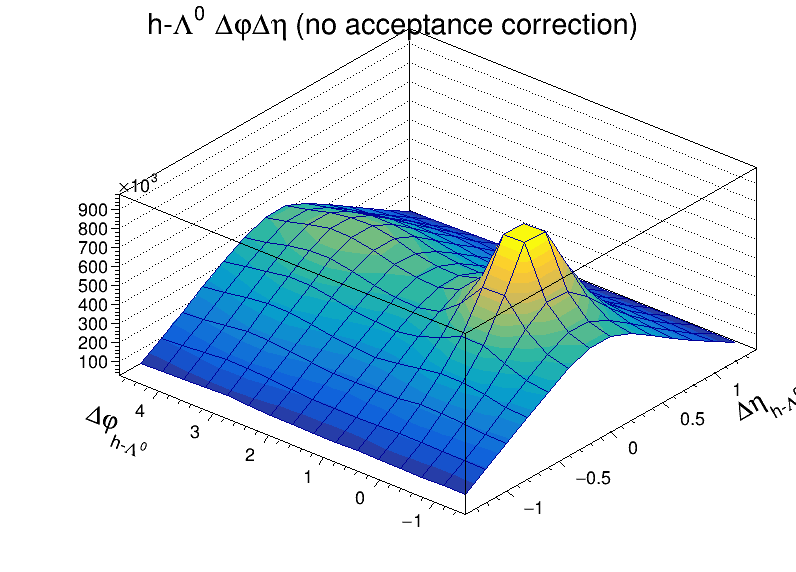

In [44]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

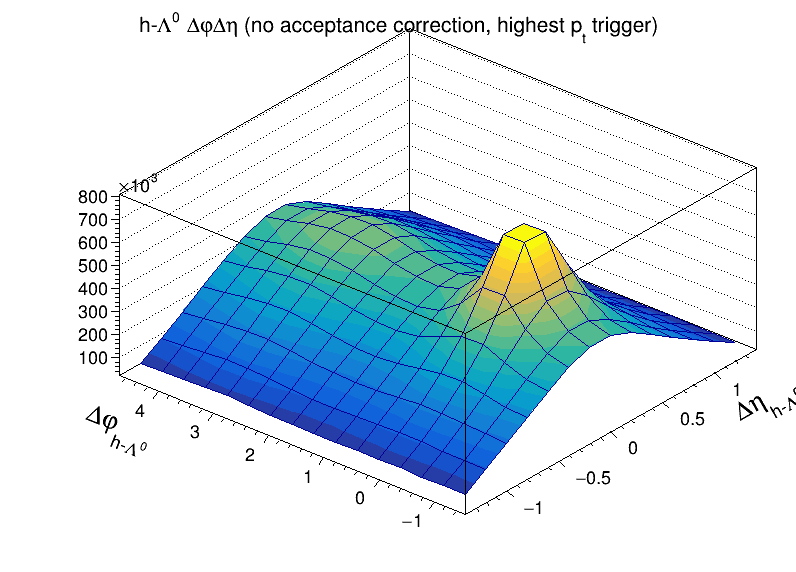

In [45]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20_highest_pt.Draw("SURF1")
c.Draw()

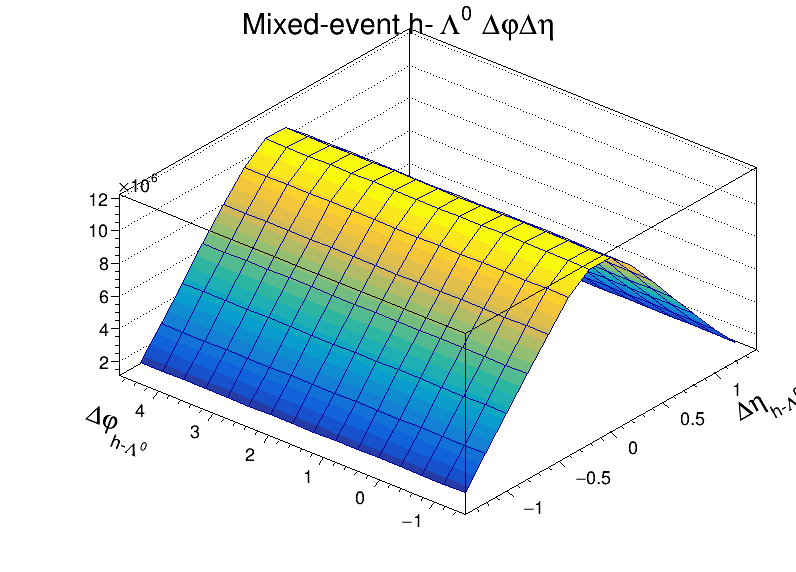

In [46]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_0_20.Draw("SURF1")
c.Draw()

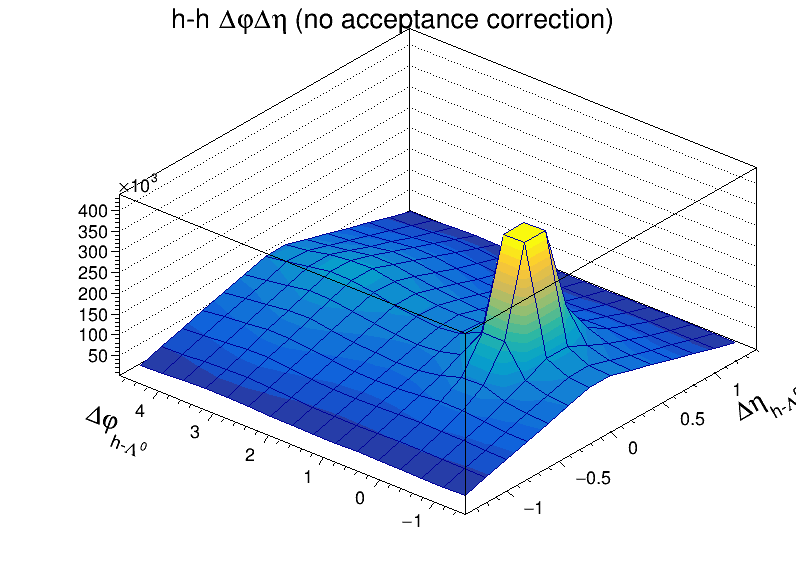

In [47]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

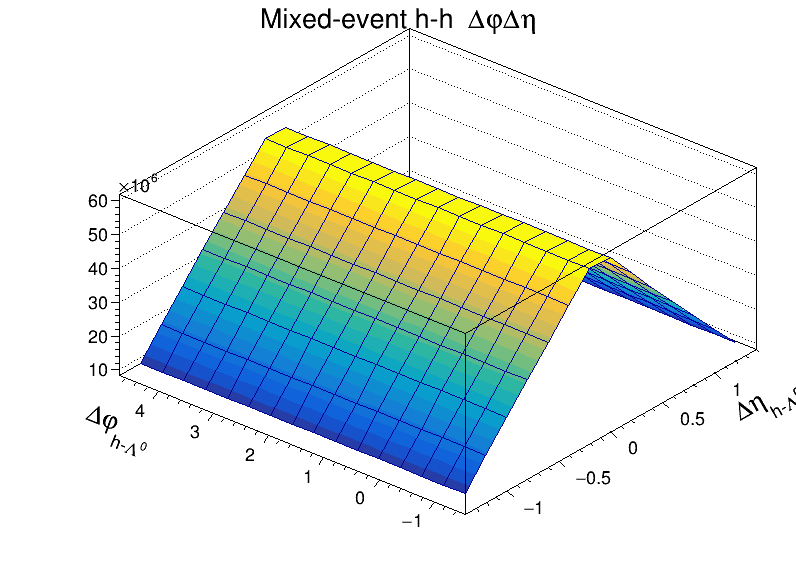

In [48]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_0_20.Draw("SURF1")
c.Draw()

In [62]:
h_lambda_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb1_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN_0_20, RSB_MAX_0_20)
RSB_MIN_0_20 = 1.18
RSB_MAX_0_20 = 1.20 - EPSILON
h_lambda_2d_mixcor_rsb2_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN_0_20, RSB_MAX_0_20)
RSB_MIN_0_20 = 1.20
RSB_MAX_0_20 = 1.22 - EPSILON
h_lambda_2d_mixcor_rsb3_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN_0_20, RSB_MAX_0_20)

Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambda_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambda_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambda_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Re

In [63]:
h_lambda_2d_mixcor_sig_0_20_highest_pt = make_mixed_corrections(h_lambda_0_20_highest_pt, h_lambda_mixed_0_20_highest_pt, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_0_20_highest_pt = make_mixed_corrections(h_lambda_0_20_highest_pt, h_lambda_mixed_0_20_highest_pt, RSB_MIN_0_20, RSB_MAX_0_20)

Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambda_highestPt_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_highestPt_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambda_highestPt_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_highestPt_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [64]:
h_h_2d_mixcor_0_20 = make_mixed_corrections(h_h_0_20, h_h_mixed_0_20, SIG_MIN, SIG_MAX, is_hh=True)
h_h_2d_mixcor_0_20_highest_pt = make_mixed_corrections(h_h_0_20_highest_pt, h_h_mixed_0_20_highest_pt, SIG_MIN, SIG_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [54]:
h_lambda_2d_mixcor_sig_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleOffset(1.3)

In [55]:
h_h_2d_mixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleOffset(1.3)

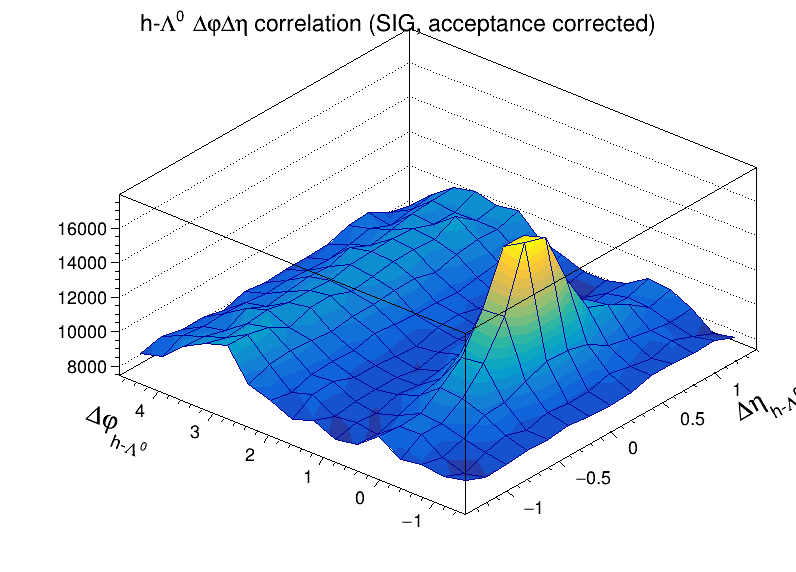

In [56]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_0_20.Draw("SURF1")
c.Draw()

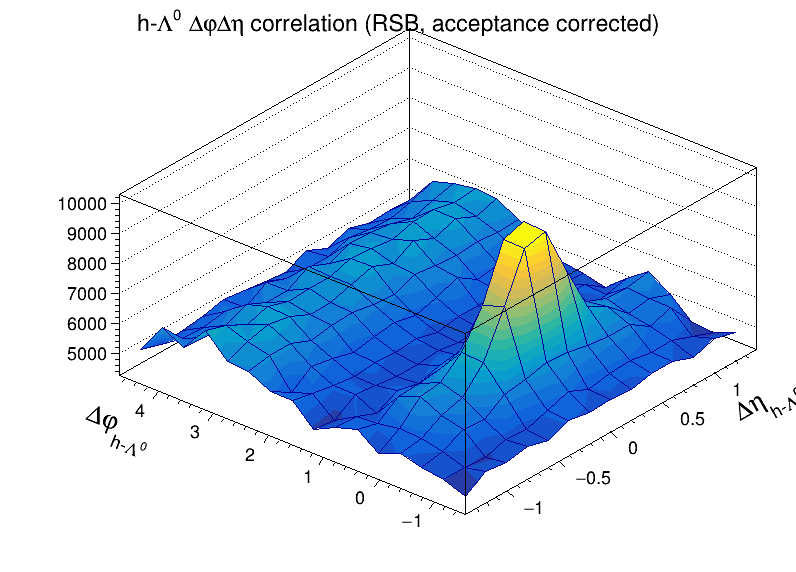

In [57]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_0_20.Draw("SURF1")
c.Draw()

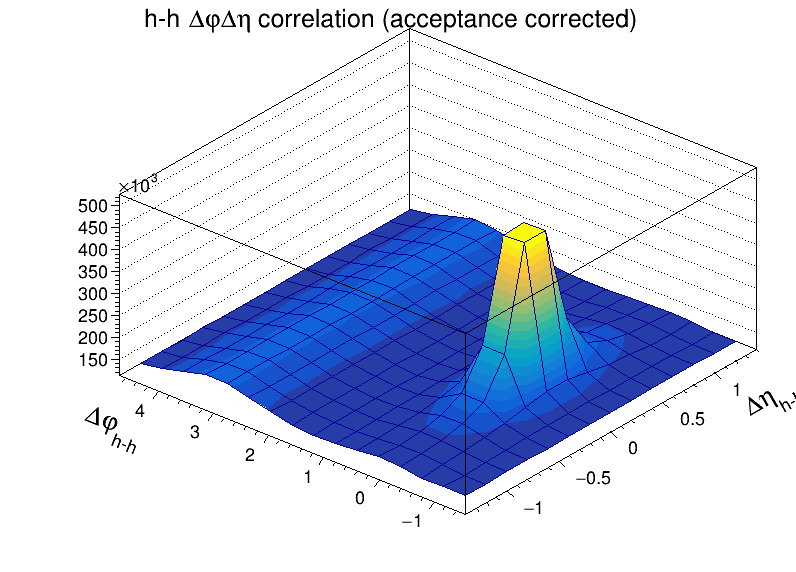

In [58]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20.Draw("SURF1")
c.Draw()

In [59]:
h_lambda_2d_mixcor_sig_0_20_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_0_20_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)

In [65]:
# per-trigger normalization done here
h_lambda_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb1_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb2_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb3_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20_highest_pt.Scale(1.0/num_trigs_0_20_highest_pt)
h_lambda_2d_mixcor_rsb_0_20_highest_pt.Scale(1.0/num_trigs_0_20_highest_pt)
h_h_2d_mixcor_0_20.Scale(1.0/num_trigs_0_20)
h_h_2d_mixcor_0_20_highest_pt.Scale(1.0/num_trigs_0_20_highest_pt)

In [66]:
# scaling by total signal/signal region done here
h_lambda_2d_mixcor_sig_0_20.Scale(scale_factor_0_20)
h_lambda_2d_mixcor_rsb1_0_20.Scale(scale_factor_0_20)
h_lambda_2d_mixcor_rsb2_0_20.Scale(scale_factor_0_20)
h_lambda_2d_mixcor_rsb3_0_20.Scale(scale_factor_0_20)

### Sideband subtraction section

In [67]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsb1_0_20.Scale(1/h_lambda_2d_mixcor_rsb1_0_20.Integral())
h_lambda_2d_mixcor_rsb2_0_20.Scale(1/h_lambda_2d_mixcor_rsb2_0_20.Integral())
h_lambda_2d_mixcor_rsb3_0_20.Scale(1/h_lambda_2d_mixcor_rsb3_0_20.Integral())

In [73]:
h_lambda_dphi_rsb1_0_20 = h_lambda_2d_mixcor_rsb1_0_20.ProjectionY("h_lambda_dphi_rsb1_0_20")
h_lambda_dphi_rsb2_0_20 = h_lambda_2d_mixcor_rsb2_0_20.ProjectionY("h_lambda_dphi_rsb2_0_20")
h_lambda_dphi_rsb3_0_20 = h_lambda_2d_mixcor_rsb3_0_20.ProjectionY("h_lambda_dphi_rsb3_0_20")
h_lambda_dphi_rsb1_0_20.GetYaxis().SetRangeUser(0.7*h_lambda_dphi_rsb1_0_20.GetMinimum(), 1.3*h_lambda_dphi_rsb1_0_20.GetMaximum())

Info in <TCanvas::Print>: pdf file figures/h_lambda_dphi_rsbcomp_0_20.pdf has been created


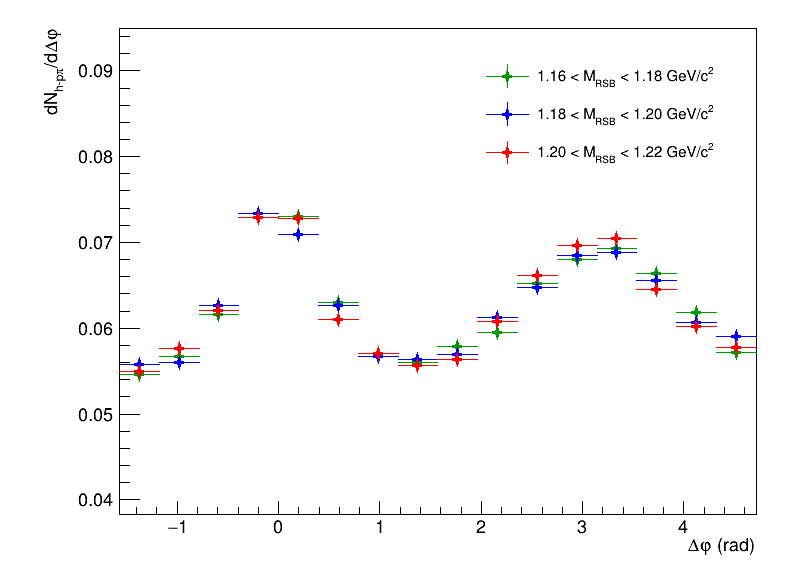

In [80]:
h_lambda_dphi_rsb1_0_20.SetTitle("")
h_lambda_dphi_rsb1_0_20.GetYaxis().SetTitle("dN_{h-p#pi}/d#Delta#varphi")
h_lambda_dphi_rsb1_0_20.GetXaxis().SetTitle("#Delta#varphi (rad)")
h_lambda_dphi_rsb1_0_20.SetMarkerStyle(43)
h_lambda_dphi_rsb1_0_20.SetMarkerSize(2)
h_lambda_dphi_rsb2_0_20.SetMarkerStyle(43)
h_lambda_dphi_rsb2_0_20.SetMarkerSize(2)
h_lambda_dphi_rsb3_0_20.SetMarkerStyle(43)
h_lambda_dphi_rsb3_0_20.SetMarkerSize(2)

h_lambda_dphi_rsb1_0_20.SetLineColor(rt.kGreen + 2)
h_lambda_dphi_rsb2_0_20.SetLineColor(rt.kBlue)
h_lambda_dphi_rsb3_0_20.SetLineColor(rt.kRed)

h_lambda_dphi_rsb1_0_20.SetMarkerColor(rt.kGreen + 2)
h_lambda_dphi_rsb2_0_20.SetMarkerColor(rt.kBlue)
h_lambda_dphi_rsb3_0_20.SetMarkerColor(rt.kRed)

h_lambda_dphi_rsb1_0_20.Draw()
h_lambda_dphi_rsb2_0_20.Draw("SAME")
h_lambda_dphi_rsb3_0_20.Draw("SAME")

leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)

leg.AddEntry(h_lambda_dphi_rsb1_0_20, "1.16 < M_{RSB} < 1.18 GeV/c^{2}", "lep")
leg.AddEntry(h_lambda_dphi_rsb2_0_20, "1.18 < M_{RSB} < 1.20 GeV/c^{2}", "lep")
leg.AddEntry(h_lambda_dphi_rsb3_0_20, "1.20 < M_{RSB} < 1.22 GeV/c^{2}", "lep")
leg.Draw("SAME")

c.Draw()
c.SaveAs("figures/h_lambda_dphi_rsbcomp_0_20.pdf")

In [288]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_rsb_0_20, -bg_integral_0_20)

True

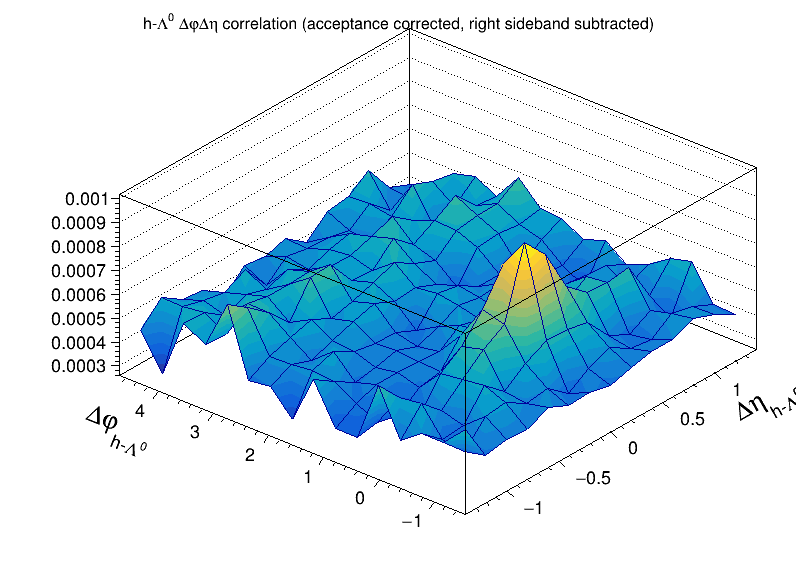

In [289]:
h_lambda_2d_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_0_20.Draw("SURF1")
c.Draw()

In [290]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_0_20_highest_pt = h_lambda_2d_mixcor_sig_0_20_highest_pt.Clone("h_lambda_2d_subtracted_0_20_highest_pt")
bg_integral_0_20_highest_pt = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20_highest_pt.Integral()
h_lambda_2d_subtracted_0_20_highest_pt.Add(h_lambda_2d_mixcor_rsb_0_20_highest_pt, -bg_integral_0_20_highest_pt)

True

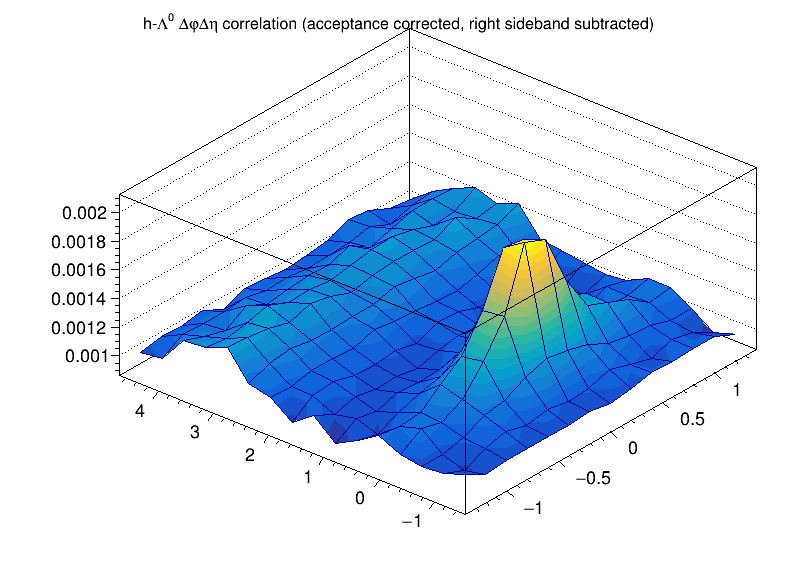

In [291]:
h_lambda_2d_subtracted_0_20_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_0_20_highest_pt.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [292]:
h_lambda_dphi_subtracted_0_20 = h_lambda_2d_subtracted_0_20.ProjectionY("h_lambda_dphi_subtracted_0_20")
h_lambda_dphi_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleOffset(0.5)

In [293]:
h_lambda_dphi_subtracted_0_20_highest_pt = h_lambda_2d_subtracted_0_20_highest_pt.ProjectionY("h_lambda_dphi_subtracted_0_20_highest_pt")
h_lambda_dphi_subtracted_0_20_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20_highest_pt.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20_highest_pt.GetXaxis().SetTitleOffset(0.5)

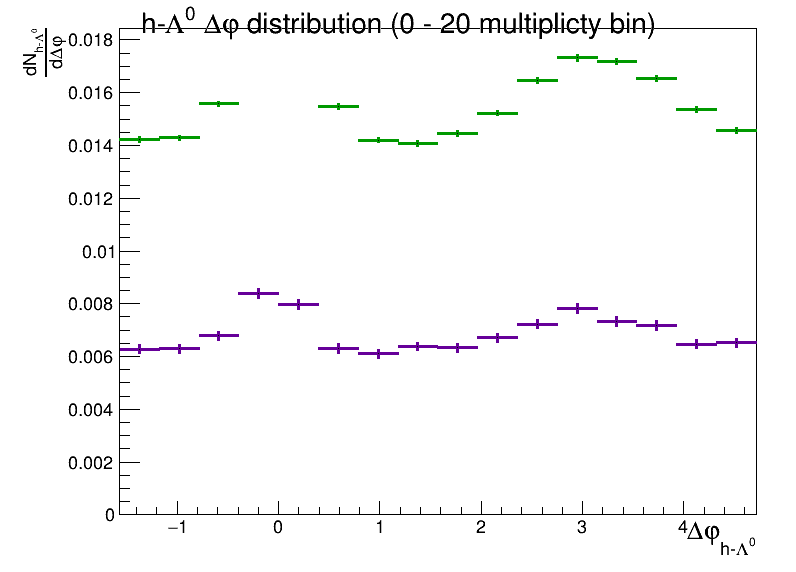

In [294]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(h_lambda_dphi_subtracted_0_20_highest_pt.GetMinimum()*0.9, 
                                                      h_lambda_dphi_subtracted_0_20.GetMaximum()*1.10)
h_lambda_dphi_subtracted_0_20.Draw()
h_lambda_dphi_subtracted_0_20_highest_pt.SetLineColor(rt.kGreen + 2)
h_lambda_dphi_subtracted_0_20_highest_pt.Draw("SAME")
c.Draw()

In [295]:
if USE_AVG:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    ue_avg_0_20 = (h_lambda_dphi_subtracted_0_20.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(16))/4

    ue_avg_error_0_20 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(16)**2))


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
    ue_avg_0_20 = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
    ue_avg_error_0_20 = h_lambda_dphi_subtracted_0_20.GetBinError(min_bin)


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [296]:
if USE_AVG:
    ue_line_0_20_highest_pt = rt.TF1("ue_line_0_20_highest_pt", "pol0", -2, 6)
    ue_upper_line_0_20_highest_pt = rt.TF1("ue_upper_line_0_20_highest_pt", "pol0", -2, 6)
    ue_lower_line_0_20_highest_pt = rt.TF1("ue_lower_line_0_20_highest_pt", "pol0", -2, 6)
    zero_line_0_20_highest_pt = rt.TF1("zero_line_0_20_highest_pt", "pol0", -2, 6)
    zero_upper_line_0_20_highest_pt = rt.TF1("zero_upper_line_0_20_highest_pt", "pol0", -2, 6)
    zero_lower_line_0_20_highest_pt = rt.TF1("zero_lower_line_0_20_highest_pt", "pol0", -2, 6)
    ue_avg_0_20_highest_pt = (h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(16))/4

    ue_avg_error_0_20_highest_pt = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(16)**2))


    ue_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt)
    ue_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_highest_pt.SetLineWidth(3)
    ue_line_0_20_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt + ue_avg_error_0_20_highest_pt)
    ue_upper_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt - ue_avg_error_0_20_highest_pt)
    ue_lower_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_0_20_highest_pt.SetParameter(0, 0)
    zero_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_highest_pt.SetLineWidth(3)
    zero_line_0_20_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_highest_pt.SetParameter(0, ue_avg_error_0_20_highest_pt)
    zero_upper_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_highest_pt.SetParameter(0, -ue_avg_error_0_20_highest_pt)
    zero_lower_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20_highest_pt = rt.TF1("ue_line_0_20_highest_pt", "pol0", -2, 6)
    ue_upper_line_0_20_highest_pt = rt.TF1("ue_upper_line_0_20_highest_pt", "pol0", -2, 6)
    ue_lower_line_0_20_highest_pt = rt.TF1("ue_lower_line_0_20_highest_pt", "pol0", -2, 6)
    zero_line_0_20_highest_pt = rt.TF1("zero_line_0_20_highest_pt", "pol0", -2, 6)
    zero_upper_line_0_20_highest_pt = rt.TF1("zero_upper_line_0_20_highest_pt", "pol0", -2, 6)
    zero_lower_line_0_20_highest_pt = rt.TF1("zero_lower_line_0_20_highest_pt", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20_highest_pt.GetMinimumBin()
    ue_avg_0_20_highest_pt = h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(min_bin)
    ue_avg_error_0_20_highest_pt = h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(min_bin)


    ue_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt)
    ue_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_highest_pt.SetLineWidth(3)
    ue_line_0_20_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt + ue_avg_error_0_20_highest_pt)
    ue_upper_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_highest_pt.SetParameter(0, ue_avg_0_20_highest_pt - ue_avg_error_0_20_highest_pt)
    ue_lower_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_0_20_highest_pt.SetParameter(0, 0)
    zero_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_highest_pt.SetLineWidth(3)
    zero_line_0_20_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_highest_pt.SetParameter(0, ue_avg_error_0_20_highest_pt)
    zero_upper_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_highest_pt.SetParameter(0, -ue_avg_error_0_20_highest_pt)
    zero_lower_line_0_20_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

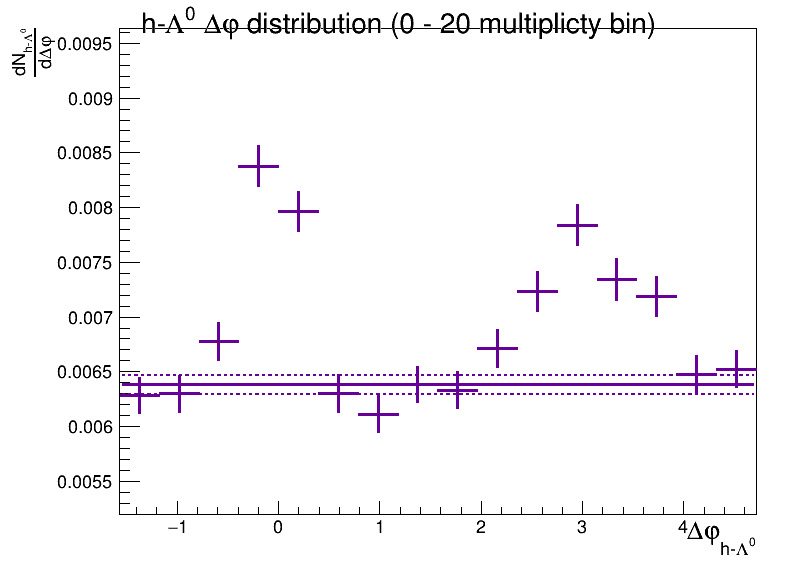

In [297]:
min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
min_val = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted_0_20.GetMaximumBin()
max_val = h_lambda_dphi_subtracted_0_20.GetBinContent(max_bin)

h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

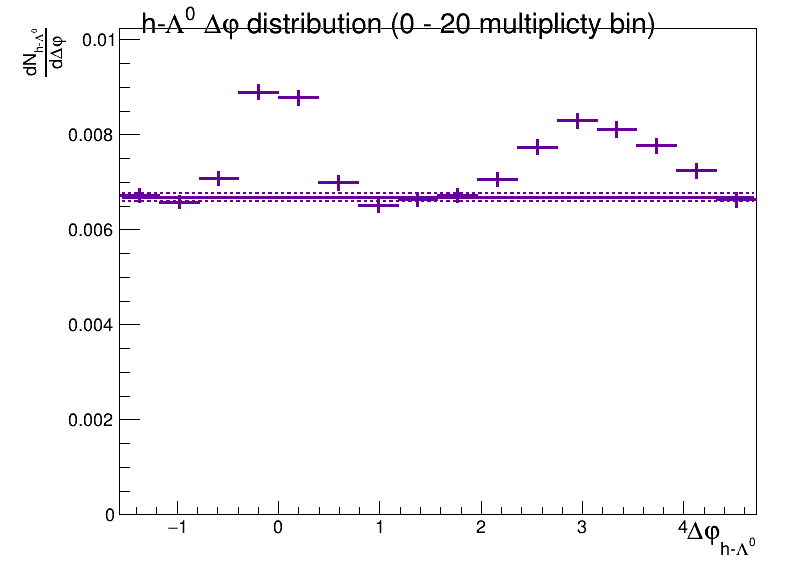

In [232]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

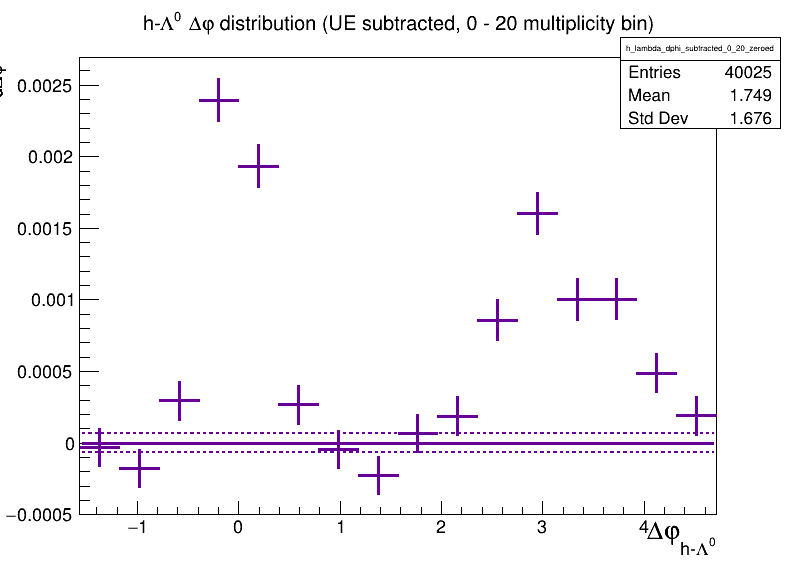

In [68]:
h_lambda_dphi_subtracted_0_20_zeroed = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_zeroed")
h_lambda_dphi_subtracted_0_20_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_0_20_zeroed.Add(ue_line_0_20, -1)
h_lambda_dphi_subtracted_0_20_zeroed.Draw()
zero_line_0_20.Draw("SAME")
zero_upper_line_0_20.Draw("SAME")
zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted_0_20.GetNbinsX()

In [ ]:
h_lambda_total_integral_0_20 = 0
h_lambda_near_integral_0_20 = 0
h_lambda_away_integral_0_20 = 0
h_lambda_ue_integral_0_20 = ue_avg_0_20*DPHI_BINS

h_lambda_total_integral_error_0_20 = 0
h_lambda_near_integral_error_0_20 = 0
h_lambda_away_integral_error_0_20 = 0
h_lambda_ue_integral_error_0_20 = ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20 += h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num) - ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20 += part
        h_lambda_near_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20 += ue_avg_error_0_20**2
    else:
        h_lambda_away_integral_0_20 += part
        h_lambda_away_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20 += ue_avg_error_0_20**2
h_lambda_total_integral_error_0_20 = math.sqrt(h_lambda_total_integral_error_0_20)
h_lambda_near_integral_error_0_20 = math.sqrt(h_lambda_near_integral_error_0_20)
h_lambda_away_integral_error_0_20 = math.sqrt(h_lambda_away_integral_error_0_20)

In [ ]:
h_lambda_total_integral_0_20_highest_pt = 0
h_lambda_near_integral_0_20_highest_pt = 0
h_lambda_away_integral_0_20_highest_pt = 0
h_lambda_ue_integral_0_20_highest_pt = ue_avg_0_20_highest_pt*DPHI_BINS

h_lambda_total_integral_error_0_20_highest_pt = 0
h_lambda_near_integral_error_0_20_highest_pt = 0
h_lambda_away_integral_error_0_20_highest_pt = 0
h_lambda_ue_integral_error_0_20_highest_pt = ue_avg_error_0_20_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20_highest_pt += h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20_highest_pt += h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20_highest_pt.GetBinContent(bin_num) - ue_avg_0_20_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20_highest_pt += part 
        h_lambda_near_integral_error_0_20_highest_pt += h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20_highest_pt += ue_avg_error_0_20_highest_pt**2
    else:
        h_lambda_away_integral_0_20_highest_pt += part 
        h_lambda_away_integral_error_0_20_highest_pt += h_lambda_dphi_subtracted_0_20_highest_pt.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20_highest_pt += ue_avg_error_0_20_highest_pt**2
h_lambda_total_integral_error_0_20_highest_pt = math.sqrt(h_lambda_total_integral_error_0_20_highest_pt)
h_lambda_near_integral_error_0_20_highest_pt = math.sqrt(h_lambda_near_integral_error_0_20_highest_pt)
h_lambda_away_integral_error_0_20_highest_pt = math.sqrt(h_lambda_away_integral_error_0_20_highest_pt)

In [ ]:
h_h_dphi_0_20 = h_h_2d_mixcor_0_20.ProjectionY("h_h_dphi_0_20")
h_h_dphi_0_20.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20.SetLineColor(rt.kBlue)
h_h_dphi_0_20.SetLineWidth(3)
h_h_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_0_20_highest_pt = h_h_2d_mixcor_0_20_highest_pt.ProjectionY("h_h_dphi_0_20_highest_pt")
h_h_dphi_0_20_highest_pt.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20_highest_pt.SetLineColor(rt.kBlue)
h_h_dphi_0_20_highest_pt.SetLineWidth(3)
h_h_dphi_0_20_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20_highest_pt.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_0_20.GetYaxis().SetRangeUser(h_h_dphi_0_20_highest_pt.GetMinimum()*0.9, 
                                       h_h_dphi_0_20.GetMaximum()*1.1)
h_h_dphi_0_20_highest_pt.SetLineColor(rt.kGreen + 2)
h_h_dphi_0_20.Draw()
h_h_dphi_0_20_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
if USE_AVG:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    hh_ue_avg_0_20 = (h_h_dphi_0_20.GetBinContent(1) 
                   + h_h_dphi_0_20.GetBinContent(8)
                   + h_h_dphi_0_20.GetBinContent(9)
                   + h_h_dphi_0_20.GetBinContent(16))/4

    hh_ue_avg_error_0_20 = (1/4)*(math.sqrt(h_h_dphi_0_20.GetBinError(1)**2 
                   + h_h_dphi_0_20.GetBinError(8)**2
                   + h_h_dphi_0_20.GetBinError(9)**2
                   + h_h_dphi_0_20.GetBinError(16)**2))


    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20.GetMinimumBin()
    hh_ue_avg_0_20 = h_h_dphi_0_20.GetBinContent(min_bin)
    hh_ue_avg_error_0_20 = h_h_dphi_0_20.GetBinError(min_bin)

    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_0_20_highest_pt = rt.TF1("hh_ue_line_0_20_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_0_20_highest_pt = rt.TF1("hh_ue_upper_line_0_20_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_0_20_highest_pt = rt.TF1("hh_ue_lower_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_line_0_20_highest_pt = rt.TF1("hh_zero_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_0_20_highest_pt = rt.TF1("hh_zero_upper_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_0_20_highest_pt = rt.TF1("hh_zero_lower_line_0_20_highest_pt", "pol0", -2, 6)
    hh_ue_avg_0_20_highest_pt = (h_h_dphi_0_20_highest_pt.GetBinContent(1) 
                   + h_h_dphi_0_20_highest_pt.GetBinContent(8)
                   + h_h_dphi_0_20_highest_pt.GetBinContent(9)
                   + h_h_dphi_0_20_highest_pt.GetBinContent(16))/4

    hh_ue_avg_error_0_20_highest_pt = (1/4)*(math.sqrt(h_h_dphi_0_20_highest_pt.GetBinError(1)**2 
                   + h_h_dphi_0_20_highest_pt.GetBinError(8)**2
                   + h_h_dphi_0_20_highest_pt.GetBinError(9)**2
                   + h_h_dphi_0_20_highest_pt.GetBinError(16)**2))


    hh_ue_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt)
    hh_ue_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_highest_pt.SetLineWidth(3)
    hh_ue_line_0_20_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt + hh_ue_avg_error_0_20_highest_pt)
    hh_ue_upper_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt - hh_ue_avg_error_0_20_highest_pt)
    hh_ue_lower_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_highest_pt.SetParameter(0, 0)
    hh_zero_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_highest_pt.SetLineWidth(3)
    hh_zero_line_0_20_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_error_0_20_highest_pt)
    hh_zero_upper_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_highest_pt.SetParameter(0, -hh_ue_avg_error_0_20_highest_pt)
    hh_zero_lower_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20_highest_pt = rt.TF1("hh_ue_line_0_20_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_0_20_highest_pt = rt.TF1("hh_ue_upper_line_0_20_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_0_20_highest_pt = rt.TF1("hh_ue_lower_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_line_0_20_highest_pt = rt.TF1("hh_zero_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_0_20_highest_pt = rt.TF1("hh_zero_upper_line_0_20_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_0_20_highest_pt = rt.TF1("hh_zero_lower_line_0_20_highest_pt", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20_highest_pt.GetMinimumBin()
    hh_ue_avg_0_20_highest_pt = h_h_dphi_0_20_highest_pt.GetBinContent(min_bin)
    hh_ue_avg_error_0_20_highest_pt = h_h_dphi_0_20_highest_pt.GetBinError(min_bin)

    hh_ue_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt)
    hh_ue_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_highest_pt.SetLineWidth(3)
    hh_ue_line_0_20_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt + hh_ue_avg_error_0_20_highest_pt)
    hh_ue_upper_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_0_20_highest_pt - hh_ue_avg_error_0_20_highest_pt)
    hh_ue_lower_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_highest_pt.SetParameter(0, 0)
    hh_zero_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_highest_pt.SetLineWidth(3)
    hh_zero_line_0_20_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_highest_pt.SetParameter(0, hh_ue_avg_error_0_20_highest_pt)
    hh_zero_upper_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_highest_pt.SetParameter(0, -hh_ue_avg_error_0_20_highest_pt)
    hh_zero_lower_line_0_20_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi_0_20.GetMinimumBin()
min_val = h_h_dphi_0_20.GetBinContent(min_bin)
max_bin = h_h_dphi_0_20.GetMaximumBin()
max_val = h_h_dphi_0_20.GetBinContent(max_bin)

h_h_dphi_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20.GetYaxis().SetRangeUser(0, h_h_dphi_0_20.GetMaximum()*1.1)
h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20_zeroed = h_h_dphi_0_20.Clone("h_h_dphi_0_20_zeroed")
h_h_dphi_0_20_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_h_dphi_0_20_zeroed.Add(hh_ue_line_0_20, -1)
h_h_dphi_0_20_zeroed.Draw()
hh_zero_line_0_20.Draw("SAME")
hh_zero_upper_line_0_20.Draw("SAME")
hh_zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_0_20 = 0
h_h_near_integral_0_20 = 0
h_h_away_integral_0_20 = 0
h_h_ue_integral_0_20 = hh_ue_avg_0_20*DPHI_BINS

h_h_total_integral_error_0_20 = 0
h_h_near_integral_error_0_20 = 0
h_h_away_integral_error_0_20 = 0
h_h_ue_integral_error_0_20 = hh_ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20 += h_h_dphi_0_20.GetBinContent(bin_num)
    h_h_total_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
    part = h_h_dphi_0_20.GetBinContent(bin_num) - hh_ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20 += part
        h_h_near_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20 += hh_ue_avg_error_0_20**2
    else:
        h_h_away_integral_0_20 += part
        h_h_away_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20 += hh_ue_avg_error_0_20**2
h_h_total_integral_error_0_20 = math.sqrt(h_h_total_integral_error_0_20)
h_h_near_integral_error_0_20 = math.sqrt(h_h_near_integral_error_0_20)
h_h_away_integral_error_0_20 = math.sqrt(h_h_away_integral_error_0_20)

In [ ]:
h_h_total_integral_0_20_highest_pt = 0
h_h_near_integral_0_20_highest_pt = 0
h_h_away_integral_0_20_highest_pt = 0
h_h_ue_integral_0_20_highest_pt = hh_ue_avg_0_20_highest_pt*DPHI_BINS

h_h_total_integral_error_0_20_highest_pt = 0
h_h_near_integral_error_0_20_highest_pt = 0
h_h_away_integral_error_0_20_highest_pt = 0
h_h_ue_integral_error_0_20_highest_pt = hh_ue_avg_error_0_20_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20_highest_pt += h_h_dphi_0_20_highest_pt.GetBinContent(bin_num)
    h_h_total_integral_error_0_20_highest_pt += h_h_dphi_0_20_highest_pt.GetBinError(bin_num)**2
    part = h_h_dphi_0_20_highest_pt.GetBinContent(bin_num) - hh_ue_avg_0_20_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20_highest_pt += part
        h_h_near_integral_error_0_20_highest_pt += h_h_dphi_0_20_highest_pt.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20_highest_pt += hh_ue_avg_error_0_20_highest_pt**2
    else:
        h_h_away_integral_0_20_highest_pt += part
        h_h_away_integral_error_0_20_highest_pt += h_h_dphi_0_20_highest_pt.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20_highest_pt += hh_ue_avg_error_0_20_highest_pt**2
h_h_total_integral_error_0_20_highest_pt = math.sqrt(h_h_total_integral_error_0_20_highest_pt)
h_h_near_integral_error_0_20_highest_pt = math.sqrt(h_h_near_integral_error_0_20_highest_pt)
h_h_away_integral_error_0_20_highest_pt = math.sqrt(h_h_away_integral_error_0_20_highest_pt)

In [ ]:
near_ratio_0_20 = h_lambda_near_integral_0_20/h_h_near_integral_0_20
away_ratio_0_20 = h_lambda_away_integral_0_20/h_h_away_integral_0_20
ue_ratio_0_20 = h_lambda_ue_integral_0_20/h_h_ue_integral_0_20
total_ratio_0_20 = h_lambda_total_integral_0_20/h_h_total_integral_0_20

near_ratio_error_0_20 = near_ratio_0_20*math.sqrt((h_lambda_near_integral_error_0_20/h_lambda_near_integral_0_20)**2
                                                 + (h_h_near_integral_error_0_20/h_h_near_integral_0_20)**2)
away_ratio_error_0_20 = away_ratio_0_20*math.sqrt((h_lambda_away_integral_error_0_20/h_lambda_away_integral_0_20)**2
                                                 + (h_h_away_integral_error_0_20/h_h_away_integral_0_20)**2)
ue_ratio_error_0_20 = ue_ratio_0_20*math.sqrt((h_lambda_ue_integral_error_0_20/h_lambda_ue_integral_0_20)**2
                                                 + (h_h_ue_integral_error_0_20/h_h_ue_integral_0_20)**2)
total_ratio_error_0_20 = total_ratio_0_20*math.sqrt((h_lambda_total_integral_error_0_20/h_lambda_total_integral_0_20)**2
                                                 + (h_h_total_integral_error_0_20/h_h_total_integral_0_20)**2)

In [ ]:
near_ratio_0_20_highest_pt = h_lambda_near_integral_0_20_highest_pt/h_h_near_integral_0_20_highest_pt
away_ratio_0_20_highest_pt = h_lambda_away_integral_0_20_highest_pt/h_h_away_integral_0_20_highest_pt
ue_ratio_0_20_highest_pt = h_lambda_ue_integral_0_20_highest_pt/h_h_ue_integral_0_20_highest_pt
total_ratio_0_20_highest_pt = h_lambda_total_integral_0_20_highest_pt/h_h_total_integral_0_20_highest_pt

near_ratio_error_0_20_highest_pt = near_ratio_0_20_highest_pt*math.sqrt((h_lambda_near_integral_error_0_20_highest_pt/h_lambda_near_integral_0_20_highest_pt)**2
                                                 + (h_h_near_integral_error_0_20_highest_pt/h_h_near_integral_0_20_highest_pt)**2)
away_ratio_error_0_20_highest_pt = away_ratio_0_20_highest_pt*math.sqrt((h_lambda_away_integral_error_0_20_highest_pt/h_lambda_away_integral_0_20_highest_pt)**2
                                                 + (h_h_away_integral_error_0_20_highest_pt/h_h_away_integral_0_20_highest_pt)**2)
ue_ratio_error_0_20_highest_pt = ue_ratio_0_20_highest_pt*math.sqrt((h_lambda_ue_integral_error_0_20_highest_pt/h_lambda_ue_integral_0_20_highest_pt)**2
                                                 + (h_h_ue_integral_error_0_20_highest_pt/h_h_ue_integral_0_20_highest_pt)**2)
total_ratio_error_0_20_highest_pt = total_ratio_0_20_highest_pt*math.sqrt((h_lambda_total_integral_error_0_20_highest_pt/h_lambda_total_integral_0_20_highest_pt)**2
                                                 + (h_h_total_integral_error_0_20_highest_pt/h_h_total_integral_0_20_highest_pt)**2)

# 20 - 50 setup

In [ ]:
input_file_20_50 = rt.TFile("~/OneDrive/Research/Output/lambda-over-hadron/data/cent_20_50_v2.root")
input_list_20_50 = input_file_20_50.Get("h-lambda")
input_file_20_50.Close()

In [ ]:
trig_dist_20_50 = input_list_20_50.FindObject("fTriggerDistEff")
lambda_dist_20_50 = input_list_20_50.FindObject("fTriggeredLambdaDist")

In [ ]:
#trig_dist_20_50_highest_pt = input_list_20_50.FindObject("fTriggerDistEff_highestPt")
trig_dist_20_50_highest_pt = input_list_20_50.FindObject("fTriggerDistEff")

In [ ]:
h_h_20_50 = input_list_20_50.FindObject("fDphiHHEff")
h_h_20_50_noeff = input_list_20_50.FindObject("fDphiHH")
h_h_mixed_20_50 = input_list_20_50.FindObject("fDphiHHMixed")

In [ ]:
#h_h_20_50_highest_pt = input_list_20_50.FindObject("fDphiHHEff_highestPt")
h_h_20_50_highest_pt = input_list_20_50.FindObject("fDphiHHEff")
#h_h_mixed_20_50_highest_pt = input_list_20_50.FindObject("fDphiHHMixed_highestPt")
h_h_mixed_20_50_highest_pt = input_list_20_50.FindObject("fDphiHHMixed")

In [ ]:
h_lambda_20_50 = input_list_20_50.FindObject("fDphiHLambdaEff")
h_lambda_ls_20_50 = input_list_20_50.FindObject("fDphiHLambdaLS")
h_lambda_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaLSMixed")

In [ ]:
h_lambda_mixed_20_50_highest_pt = input_list_20_50.FindObject("fDphiHLambdaMixed")
#h_lambda_mixed_20_50_highest_pt = input_list_20_50.FindObject("fDphiHLambdaMixed_highestPt")
h_lambda_20_50_highest_pt = input_list_20_50.FindObject("fDphiHLambdaEff")
#h_lambda_20_50_highest_pt = input_list_20_50.FindObject("fDphiHLambdaEff_highestPt")

In [ ]:
# Setting the trigger Pt (this is never changed again)
trig_dist_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
trig_dist_20_50_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50_noeff.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_20_50_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_20_50_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_20_50_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [ ]:
# Setting the associated Pt (this is never changed again)
lambda_dist_20_50.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50_noeff.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_20_50_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_20_50_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_20_50_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [ ]:
trig_pt_dist_20_50 = trig_dist_20_50.Projection(0).Clone("trig_pt_dist_20_50")
trig_phi_dist_20_50 = trig_dist_20_50.Projection(1).Clone("trig_phi_dist_20_50")
trig_eta_dist_20_50 = trig_dist_20_50.Projection(2).Clone("trig_eta_dist_20_50")
trig_2d_dist_20_50 = trig_dist_20_50.Projection(0, 3).Clone("trig_2d_dist_20_50")

trig_pt_dist_20_50.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_20_50.Sumw2()
trig_pt_dist_20_50.SetLineColor(rt.kRed)

trig_phi_dist_20_50.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_20_50.Sumw2()
trig_phi_dist_20_50.SetLineColor(rt.kRed)

trig_eta_dist_20_50.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_20_50.Sumw2()
trig_eta_dist_20_50.SetLineColor(rt.kRed)

In [ ]:
trig_pt_dist_20_50_highest_pt = trig_dist_20_50_highest_pt.Projection(0).Clone("trig_pt_dist_20_50_highest_pt")
trig_phi_dist_20_50_highest_pt = trig_dist_20_50_highest_pt.Projection(1).Clone("trig_phi_dist_20_50_highest_pt")
trig_eta_dist_20_50_highest_pt = trig_dist_20_50_highest_pt.Projection(2).Clone("trig_eta_dist_20_50_highest_pt")
trig_2d_dist_20_50_highest_pt = trig_dist_20_50_highest_pt.Projection(0, 3).Clone("trig_2d_dist_20_50_highest_pt")

trig_pt_dist_20_50_highest_pt.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_20_50_highest_pt.Sumw2()
trig_pt_dist_20_50_highest_pt.SetLineColor(rt.kRed)

trig_phi_dist_20_50_highest_pt.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_20_50_highest_pt.Sumw2()
trig_phi_dist_20_50_highest_pt.SetLineColor(rt.kRed)

trig_eta_dist_20_50_highest_pt.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_20_50_highest_pt.Sumw2()
trig_eta_dist_20_50_highest_pt.SetLineColor(rt.kRed)

In [ ]:
num_trigs_20_50 = trig_2d_dist_20_50.Integral()
num_trigs_20_50_highest_pt = trig_2d_dist_20_50_highest_pt.Integral()

In [ ]:
trig_pt_dist_20_50.Draw()
trig_pt_dist_20_50_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_20_50_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
trig_pt_dist_20_50.Scale(1/num_trigs_20_50)
trig_pt_dist_20_50_highest_pt.Scale(1/num_trigs_20_50_highest_pt)

In [ ]:
trig_pt_dist_20_50.SetTitle("Trigger p_{T} distribution (red: all, blue:highest, normalized)")
trig_pt_dist_20_50.Draw()
trig_pt_dist_20_50_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_20_50_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
trig_eta_dist_20_50.Draw()
c.Draw()

In [ ]:
trig_phi_dist_20_50.Draw()
c.Draw()

### Signal analysis section

In [ ]:
# eta cuts first
lambda_dist_20_50.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_20_50 = lambda_dist_20_50.Projection(3).Clone("lambda_mass_dist_20_50")

In [ ]:
lambda_mass_dist_20_50.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_20_50.Sumw2()
lambda_mass_dist_20_50.SetLineWidth(2)
lambda_mass_dist_20_50.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_20_50.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

In [ ]:
lambda_mass_dist_20_50.Draw()
c.Draw()

In [ ]:
bin_1 = lambda_mass_dist_20_50.FindBin(1.09)
bin_2 = lambda_mass_dist_20_50.FindBin(1.15)
bin_3 = lambda_mass_dist_20_50.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_20_50.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_20_50.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_20_50.GetBinContent(bin_3)]
bg_starting_params_20_50 = get_parabola(point_one, point_two, point_three)

In [ ]:
lambda_mass_fit_20_50 = rt.TF1("lambda_mass_fit_20_50", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_20_50.SetNpx(1000)
lambda_mass_fit_20_50.SetParameter(0, 1.36753e01)
lambda_mass_fit_20_50.FixParameter(1, 1.11581)
lambda_mass_fit_20_50.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_20_50.SetParameter(3, 6.04166e-03)
lambda_mass_fit_20_50.SetParameter(4, bg_starting_params_20_50[0])
lambda_mass_fit_20_50.SetParameter(5, bg_starting_params_20_50[1])
lambda_mass_fit_20_50.SetParameter(6, bg_starting_params_20_50[2])

In [ ]:
lambda_mass_dist_fit_20_50 = lambda_mass_dist_20_50.Clone("lambda_mass_dist_fit_20_50")
lambda_mass_dist_fit_20_50.Fit(lambda_mass_fit_20_50, "RS")
lambda_mass_dist_fit_20_50.Draw()
c.Draw()

In [ ]:
bg_fit_20_50 = rt.TF1("bg_fit_20_50", "pol2", 1.09, 1.15)
bg_fit_20_50.SetParameter(0, lambda_mass_fit_20_50.GetParameter(4))
bg_fit_20_50.SetParameter(1, lambda_mass_fit_20_50.GetParameter(5))
bg_fit_20_50.SetParameter(2, lambda_mass_fit_20_50.GetParameter(6))
bg_fit_20_50.SetNpx(1000)
bg_fit_20_50.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_20_50.Draw()
bg_fit_20_50.Draw("SAME")
c.Draw()

In [ ]:
left_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MIN)
right_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MAX)

lambda_bg_20_50 = 0
lambda_total_20_50 = 0
for bin_num in range(left_signal_bin_20_50, right_signal_bin_20_50 + 1):
    bin_center = lambda_mass_dist_fit_20_50.GetBinCenter(bin_num)
    lambda_bg_20_50 += bg_fit_20_50.Eval(bin_center)
    lambda_total_20_50 += lambda_mass_dist_fit_20_50.GetBinContent(bin_num)

lambda_signal_20_50 = lambda_total_20_50 - lambda_bg_20_50
lambda_signal_total_ratio_20_50 = lambda_signal_20_50/lambda_total_20_50
lambda_signal_bg_ratio_20_50 = lambda_signal_20_50/lambda_bg_20_50
print(f"The 20-50 lambda signal is: {lambda_signal_20_50}")
print(f"The 20-50 lambda background is: {lambda_bg_20_50}")
print(f"The 20-50 lambda S/B is: {lambda_signal_bg_ratio_20_50}")
print(f"The 20-50 lambda S/T is: {lambda_signal_total_ratio_20_50}")
print(f"The 20-50 lambda significance is: {lambda_signal_20_50/math.sqrt(lambda_signal_20_50 + lambda_bg_20_50)}")

Extracted signal: 383635.9734414212


Warning in <TFile::Init>: file mc_templates.root probably not closed, trying to recover
Info in <TFile::Recover>: mc_templates.root, recovered key TH1D:lambda_mass_dist at address 230
Info in <TFile::Recover>: mc_templates.root, recovered key TH1D:lambda_mass_dist_nobg at address 3094
Warning in <TFile::Init>: successfully recovered 2 keys
Info in <TCanvas::Print>: pdf file figures/lambda_mass_0_20_resonance_signal_comp.pdf has been created


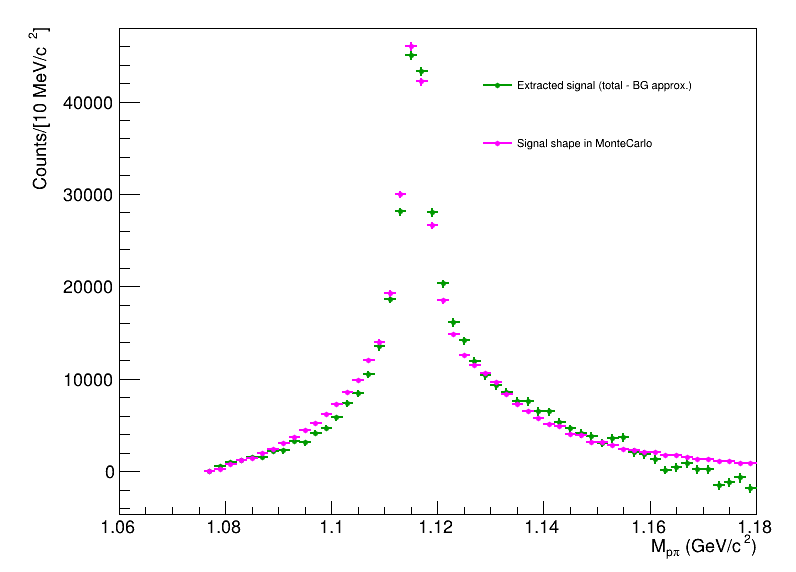

In [ ]:
left_bin = residual_20_50.FindBin(SIG_MIN)
right_bin = residual_20_50.FindBin(SIG_MAX)

print(f"Extracted signal: {residual_20_50.Integral()}")
templates_file = rt.TFile("mc_templates.root", "READ")

lambda_mass_template = templates_file.Get("lambda_mass_dist_nobg")
lambda_mass_template.Rebin(2)
scale_factor_20_50 = lambda_mass_template.Integral(1, residual_20_50.FindBin(1.16))/lambda_mass_template.Integral(left_bin, right_bin)

mass_signal_legend_20_50 = rt.TLegend(0.6, 0.7, 0.8, 0.9)
mass_signal_legend_20_50.SetTextSize(0.02)
mass_signal_legend_20_50.SetBorderSize(0)
mass_signal_legend_20_50.SetFillStyle(0)
mass_signal_legend_20_50.AddEntry(residual_20_50, "Extracted signal (total - BG approx.)", "lp")
mass_signal_legend_20_50.AddEntry(lambda_mass_template, "Signal shape in MonteCarlo", "lp")

residual_20_50.GetXaxis().SetRangeUser(1.06, 1.18)
lambda_mass_template.GetXaxis().SetRangeUser(1.06, 1.18)

lambda_mass_template.Scale(residual_20_50.Integral(left_bin, right_bin)/lambda_mass_template.Integral(left_bin, right_bin))

residual_20_50.Draw()
lambda_mass_template.Draw("SAME")
mass_signal_legend_20_50.Draw("SAME")
c.Draw()
c.SaveAs("figures/lambda_mass_20_50_resonance_signal_comp.pdf")

### Mixed event correction section

In [ ]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_20_50 = h_lambda_20_50.Projection(4, axes)
h_lambda_20_50_highest_pt = h_lambda_20_50_highest_pt.Projection(4, axes)
h_lambda_ls_20_50 = h_lambda_ls_20_50.Projection(4, axes)
h_lambda_mixed_20_50 = h_lambda_mixed_20_50.Projection(4, axes)
h_lambda_mixed_20_50_highest_pt = h_lambda_mixed_20_50_highest_pt.Projection(4, axes)
h_lambda_ls_mixed_20_50 = h_lambda_ls_mixed_20_50.Projection(4, axes)

In [ ]:
h_h_20_50 = h_h_20_50.Projection(2, 3, 4)
h_h_20_50_highest_pt = h_h_20_50_highest_pt.Projection(2, 3, 4)
h_h_mixed_20_50 = h_h_mixed_20_50.Projection(2, 3, 4)
h_h_mixed_20_50_highest_pt = h_h_mixed_20_50_highest_pt.Projection(2, 3, 4)

In [ ]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_20_50 = h_lambda_20_50.Projection(0, 1).Clone("h_lambda_2d_nomixcor_20_50")
h_lambda_2d_nomixcor_20_50_highest_pt = h_lambda_20_50_highest_pt.Projection(0, 1).Clone("h_lambda_2d_nomixcor_20_50_highest_pt")
h_lambda_ls_2d_nomixcor_20_50 = h_lambda_ls_20_50.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_20_50")
h_lambda_mixed_2d_20_50 = h_lambda_mixed_20_50.Projection(0, 1).Clone("h_lambda_mixed_2d_20_50")
h_lambda_mixed_2d_20_50_highest_pt = h_lambda_mixed_20_50_highest_pt.Projection(0, 1).Clone("h_lambda_mixed_2d_20_50_highest_pt")

In [ ]:
h_h_2d_nomixcor_20_50 = h_h_20_50_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_20_50")
h_h_2d_nomixcor_20_50_highest_pt = h_h_20_50_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_20_50_highest_pt")
h_h_mixed_2d_20_50 = h_h_mixed_20_50.Project3D("xye").Clone("h_h_mixed_2d_20_50")
h_h_mixed_2d_20_50_highest_pt = h_h_mixed_20_50_highest_pt.Project3D("xye").Clone("h_h_mixed_2d_20_50_highest_pt")

In [ ]:
h_lambda_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_ls_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_20_50.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_20_50_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, highest p_{t} trigger)")
h_lambda_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_20_50_highest_pt.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (highest p_{T} trigger)")
h_lambda_mixed_2d_20_50_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50_highest_pt.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_nomixcor_20_50.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_20_50.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_20_50_highest_pt.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, highest p_{T} trigger)")
h_h_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_20_50_highest_pt.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_20_50_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50_highest_pt.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_20_50_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_20_50_highest_pt.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_20_50.Draw("SURF1")
c.Draw()

In [ ]:
h_lambda_2d_mixcor_lsb_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, RSB_MIN, RSB_MAX)

In [ ]:
h_lambda_2d_mixcor_lsb_20_50_highest_pt = make_mixed_corrections(h_lambda_20_50_highest_pt, h_lambda_mixed_20_50_highest_pt, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_20_50_highest_pt = make_mixed_corrections(h_lambda_20_50_highest_pt, h_lambda_mixed_20_50_highest_pt, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_20_50_highest_pt = make_mixed_corrections(h_lambda_20_50_highest_pt, h_lambda_mixed_20_50_highest_pt, RSB_MIN, RSB_MAX)

In [ ]:
h_h_2d_mixcor_20_50 = make_mixed_corrections(h_h_20_50, h_h_mixed_20_50, LSB_MIN, LSB_MAX, is_hh=True)
h_h_2d_mixcor_20_50_highest_pt = make_mixed_corrections(h_h_20_50_highest_pt, h_h_mixed_20_50_highest_pt, LSB_MIN, LSB_MAX, is_hh=True)

In [ ]:
h_lambda_2d_mixcor_lsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_mixcor_20_50.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_20_50.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_20_50.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_20_50.Draw("SURF1")
c.Draw()

In [ ]:
h_lambda_2d_mixcor_lsb_20_50_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_20_50_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_20_50_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_20_50_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)

In [ ]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_2d_mixcor_sig_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_2d_mixcor_rsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_2d_mixcor_lsb_20_50_highest_pt.Scale(1.0/num_trigs_20_50_highest_pt)
h_lambda_2d_mixcor_sig_20_50_highest_pt.Scale(1.0/num_trigs_20_50_highest_pt)
h_lambda_2d_mixcor_rsb_20_50_highest_pt.Scale(1.0/num_trigs_20_50_highest_pt)
h_lambda_ls_2d_mixcor_lsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_ls_2d_mixcor_sig_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_ls_2d_mixcor_rsb_20_50.Scale(1.0/num_trigs_20_50)
h_h_2d_mixcor_20_50.Scale(1.0/num_trigs_20_50)
h_h_2d_mixcor_20_50_highest_pt.Scale(1.0/num_trigs_20_50_highest_pt)

### Sideband subtraction section

In [ ]:
# Generate sum of 2 distributions (for USE_BOTH method)
h_lambda_2d_mixcor_rsblsb_20_50 = h_lambda_2d_mixcor_rsb_20_50.Clone("h_lambda_2d_mixcor_rsblsb_20_50")
h_lambda_2d_mixcor_rsblsb_20_50.Add(h_lambda_2d_mixcor_lsb_20_50)

In [ ]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsblsb_20_50.Scale(1/h_lambda_2d_mixcor_rsblsb_20_50.Integral())
h_lambda_2d_mixcor_rsb_20_50.Scale(1/h_lambda_2d_mixcor_rsb_20_50.Integral())
h_lambda_2d_mixcor_lsb_20_50.Scale(1/h_lambda_2d_mixcor_lsb_20_50.Integral())

In [ ]:
h_lambda_dphi_rsb_20_50 = h_lambda_2d_mixcor_rsb_20_50.ProjectionY("h_lambda_dphi_rsb_20_50")
h_lambda_dphi_lsb_20_50 = h_lambda_2d_mixcor_lsb_20_50.ProjectionY("h_lambda_dphi_lsb_20_50")
h_lambda_dphi_rsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (RSB, acceptance corrected)")
h_lambda_dphi_rsb_20_50.SetLineColor(rt.kMagenta)
h_lambda_dphi_lsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (LSB and RSB, normalized to 1)")
h_lambda_dphi_lsb_20_50.SetLineColor(rt.kBlue)
h_lambda_dphi_lsb_20_50.Draw()
h_lambda_dphi_rsb_20_50.Draw("SAME")
c.Draw()

In [ ]:
if USE_RSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50 = h_lambda_2d_mixcor_sig_20_50.Clone("h_lambda_2d_subtracted_20_50")
    bg_integral_20_50 = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50.Integral()
    h_lambda_2d_subtracted_20_50.Add(h_lambda_2d_mixcor_rsb_20_50, -bg_integral_20_50)
elif USE_LSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50 = h_lambda_2d_mixcor_sig_20_50.Clone("h_lambda_2d_subtracted_20_50")
    bg_integral_20_50 = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50.Integral()
    h_lambda_2d_subtracted_20_50.Add(h_lambda_2d_mixcor_lsb_20_50, -bg_integral_20_50)
elif USE_BOTH:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50 = h_lambda_2d_mixcor_sig_20_50.Clone("h_lambda_2d_subtracted_20_50")
    bg_integral_20_50 = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50.Integral()
    h_lambda_2d_subtracted_20_50.Add(h_lambda_2d_mixcor_rsblsb_20_50, -bg_integral_20_50)
else:
    raise NotImplementedError("Must have USE_RSB or USE_LSB selected")

In [ ]:
h_lambda_2d_subtracted_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_20_50.Draw("SURF1")
c.Draw()

In [ ]:
# Generate sum of 2 distributions (for USE_BOTH method)
h_lambda_2d_mixcor_rsblsb_20_50_highest_pt = h_lambda_2d_mixcor_rsb_20_50_highest_pt.Clone("h_lambda_2d_mixcor_rsblsb_20_50_highest_pt")
h_lambda_2d_mixcor_rsblsb_20_50_highest_pt.Add(h_lambda_2d_mixcor_lsb_20_50_highest_pt)

In [ ]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsb_20_50_highest_pt.Scale(1/h_lambda_2d_mixcor_rsb_20_50_highest_pt.Integral())
h_lambda_2d_mixcor_lsb_20_50_highest_pt.Scale(1/h_lambda_2d_mixcor_lsb_20_50_highest_pt.Integral())
h_lambda_2d_mixcor_rsblsb_20_50_highest_pt.Scale(1/h_lambda_2d_mixcor_rsblsb_20_50_highest_pt.Integral())

In [ ]:
if USE_RSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50_highest_pt = h_lambda_2d_mixcor_sig_20_50_highest_pt.Clone("h_lambda_2d_subtracted_20_50_highest_pt")
    bg_integral_20_50_highest_pt = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50_highest_pt.Integral()
    h_lambda_2d_subtracted_20_50_highest_pt.Add(h_lambda_2d_mixcor_rsb_20_50_highest_pt, -bg_integral_20_50_highest_pt)
elif USE_LSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50_highest_pt = h_lambda_2d_mixcor_sig_20_50_highest_pt.Clone("h_lambda_2d_subtracted_20_50_highest_pt")
    bg_integral_20_50_highest_pt = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50_highest_pt.Integral()
    h_lambda_2d_subtracted_20_50_highest_pt.Add(h_lambda_2d_mixcor_lsb_20_50_highest_pt, -bg_integral_20_50_highest_pt)
elif USE_BOTH:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_20_50_highest_pt = h_lambda_2d_mixcor_sig_20_50_highest_pt.Clone("h_lambda_2d_subtracted_20_50_highest_pt")
    bg_integral_20_50_highest_pt = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50_highest_pt.Integral()
    h_lambda_2d_subtracted_20_50_highest_pt.Add(h_lambda_2d_mixcor_rsblsb_20_50_highest_pt, -bg_integral_20_50_highest_pt)
else:
    raise NotImplementedError("Must have USE_RSB or USE_LSB selected")

In [ ]:
h_lambda_2d_subtracted_20_50_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_20_50_highest_pt.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [ ]:
h_lambda_dphi_subtracted_20_50 = h_lambda_2d_subtracted_20_50.ProjectionY("h_lambda_dphi_subtracted_20_50")
h_lambda_dphi_subtracted_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_lambda_dphi_subtracted_20_50.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_20_50.SetLineWidth(3)
h_lambda_dphi_subtracted_20_50.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_20_50.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_lambda_dphi_subtracted_20_50_highest_pt = h_lambda_2d_subtracted_20_50_highest_pt.ProjectionY("h_lambda_dphi_subtracted_20_50_highest_pt")
h_lambda_dphi_subtracted_20_50_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_lambda_dphi_subtracted_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_20_50_highest_pt.SetLineWidth(3)
h_lambda_dphi_subtracted_20_50_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_20_50_highest_pt.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_lambda_dphi_subtracted_20_50.GetYaxis().SetRangeUser(h_lambda_dphi_subtracted_20_50_highest_pt.GetMinimum()*0.9, 
                                                      h_lambda_dphi_subtracted_20_50.GetMaximum()*1.10)
h_lambda_dphi_subtracted_20_50.Draw()
h_lambda_dphi_subtracted_20_50_highest_pt.SetLineColor(rt.kGreen + 2)
h_lambda_dphi_subtracted_20_50_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
# AGAIN PLEASE GET RID OF THIS
h_lambda_dphi_subtracted_20_50.Scale(1/scaling_factor_20_50)

In [ ]:
if USE_AVG:
    ue_line_20_50 = rt.TF1("ue_line_20_50", "pol0", -2, 6)
    ue_upper_line_20_50 = rt.TF1("ue_upper_line_20_50", "pol0", -2, 6)
    ue_lower_line_20_50 = rt.TF1("ue_lower_line_20_50", "pol0", -2, 6)
    zero_line_20_50 = rt.TF1("zero_line_20_50", "pol0", -2, 6)
    zero_upper_line_20_50 = rt.TF1("zero_upper_line_20_50", "pol0", -2, 6)
    zero_lower_line_20_50 = rt.TF1("zero_lower_line_20_50", "pol0", -2, 6)
    ue_avg_20_50 = (h_lambda_dphi_subtracted_20_50.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_20_50.GetBinContent(8)
                   + h_lambda_dphi_subtracted_20_50.GetBinContent(9)
                   + h_lambda_dphi_subtracted_20_50.GetBinContent(16))/4

    ue_avg_error_20_50 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_20_50.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_20_50.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_20_50.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_20_50.GetBinError(16)**2))


    ue_line_20_50.SetParameter(0, ue_avg_20_50)
    ue_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_line_20_50.SetLineWidth(3)
    ue_line_20_50.SetLineStyle(rt.kSolid)

    ue_upper_line_20_50.SetParameter(0, ue_avg_20_50 + ue_avg_error_20_50)
    ue_upper_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_upper_line_20_50.SetLineStyle(rt.kDashed)

    ue_lower_line_20_50.SetParameter(0, ue_avg_20_50 - ue_avg_error_20_50)
    ue_lower_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_lower_line_20_50.SetLineStyle(rt.kDashed)

    zero_line_20_50.SetParameter(0, 0)
    zero_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_line_20_50.SetLineWidth(3)
    zero_line_20_50.SetLineStyle(rt.kSolid)
    zero_upper_line_20_50.SetParameter(0, ue_avg_error_20_50)
    zero_upper_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_upper_line_20_50.SetLineStyle(rt.kDashed)
    zero_lower_line_20_50.SetParameter(0, -ue_avg_error_20_50)
    zero_lower_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_lower_line_20_50.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_20_50 = rt.TF1("ue_line_20_50", "pol0", -2, 6)
    ue_upper_line_20_50 = rt.TF1("ue_upper_line_20_50", "pol0", -2, 6)
    ue_lower_line_20_50 = rt.TF1("ue_lower_line_20_50", "pol0", -2, 6)
    zero_line_20_50 = rt.TF1("zero_line_20_50", "pol0", -2, 6)
    zero_upper_line_20_50 = rt.TF1("zero_upper_line_20_50", "pol0", -2, 6)
    zero_lower_line_20_50 = rt.TF1("zero_lower_line_20_50", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_20_50.GetMinimumBin()
    ue_avg_20_50 = h_lambda_dphi_subtracted_20_50.GetBinContent(min_bin)
    ue_avg_error_20_50 = h_lambda_dphi_subtracted_20_50.GetBinError(min_bin)


    ue_line_20_50.SetParameter(0, ue_avg_20_50)
    ue_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_line_20_50.SetLineWidth(3)
    ue_line_20_50.SetLineStyle(rt.kSolid)

    ue_upper_line_20_50.SetParameter(0, ue_avg_20_50 + ue_avg_error_20_50)
    ue_upper_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_upper_line_20_50.SetLineStyle(rt.kDashed)

    ue_lower_line_20_50.SetParameter(0, ue_avg_20_50 - ue_avg_error_20_50)
    ue_lower_line_20_50.SetLineColor(rt.kViolet - 6)
    ue_lower_line_20_50.SetLineStyle(rt.kDashed)

    zero_line_20_50.SetParameter(0, 0)
    zero_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_line_20_50.SetLineWidth(3)
    zero_line_20_50.SetLineStyle(rt.kSolid)
    zero_upper_line_20_50.SetParameter(0, ue_avg_error_20_50)
    zero_upper_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_upper_line_20_50.SetLineStyle(rt.kDashed)
    zero_lower_line_20_50.SetParameter(0, -ue_avg_error_20_50)
    zero_lower_line_20_50.SetLineColor(rt.kViolet - 6)
    zero_lower_line_20_50.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    ue_line_20_50_highest_pt = rt.TF1("ue_line_20_50_highest_pt", "pol0", -2, 6)
    ue_upper_line_20_50_highest_pt = rt.TF1("ue_upper_line_20_50_highest_pt", "pol0", -2, 6)
    ue_lower_line_20_50_highest_pt = rt.TF1("ue_lower_line_20_50_highest_pt", "pol0", -2, 6)
    zero_line_20_50_highest_pt = rt.TF1("zero_line_20_50_highest_pt", "pol0", -2, 6)
    zero_upper_line_20_50_highest_pt = rt.TF1("zero_upper_line_20_50_highest_pt", "pol0", -2, 6)
    zero_lower_line_20_50_highest_pt = rt.TF1("zero_lower_line_20_50_highest_pt", "pol0", -2, 6)
    ue_avg_20_50_highest_pt = (h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(8)
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(9)
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(16))/4

    ue_avg_error_20_50_highest_pt = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(16)**2))


    ue_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt)
    ue_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_20_50_highest_pt.SetLineWidth(3)
    ue_line_20_50_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt + ue_avg_error_20_50_highest_pt)
    ue_upper_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt - ue_avg_error_20_50_highest_pt)
    ue_lower_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_20_50_highest_pt.SetParameter(0, 0)
    zero_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_20_50_highest_pt.SetLineWidth(3)
    zero_line_20_50_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_20_50_highest_pt.SetParameter(0, ue_avg_error_20_50_highest_pt)
    zero_upper_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_20_50_highest_pt.SetParameter(0, -ue_avg_error_20_50_highest_pt)
    zero_lower_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_20_50_highest_pt = rt.TF1("ue_line_20_50_highest_pt", "pol0", -2, 6)
    ue_upper_line_20_50_highest_pt = rt.TF1("ue_upper_line_20_50_highest_pt", "pol0", -2, 6)
    ue_lower_line_20_50_highest_pt = rt.TF1("ue_lower_line_20_50_highest_pt", "pol0", -2, 6)
    zero_line_20_50_highest_pt = rt.TF1("zero_line_20_50_highest_pt", "pol0", -2, 6)
    zero_upper_line_20_50_highest_pt = rt.TF1("zero_upper_line_20_50_highest_pt", "pol0", -2, 6)
    zero_lower_line_20_50_highest_pt = rt.TF1("zero_lower_line_20_50_highest_pt", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_20_50_highest_pt.GetMinimumBin()
    ue_avg_20_50_highest_pt = h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(min_bin)
    ue_avg_error_20_50_highest_pt = h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(min_bin)


    ue_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt)
    ue_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_20_50_highest_pt.SetLineWidth(3)
    ue_line_20_50_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt + ue_avg_error_20_50_highest_pt)
    ue_upper_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_20_50_highest_pt.SetParameter(0, ue_avg_20_50_highest_pt - ue_avg_error_20_50_highest_pt)
    ue_lower_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_20_50_highest_pt.SetParameter(0, 0)
    zero_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_20_50_highest_pt.SetLineWidth(3)
    zero_line_20_50_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_20_50_highest_pt.SetParameter(0, ue_avg_error_20_50_highest_pt)
    zero_upper_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_20_50_highest_pt.SetParameter(0, -ue_avg_error_20_50_highest_pt)
    zero_lower_line_20_50_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_lambda_dphi_subtracted_20_50.GetMinimumBin()
min_val = h_lambda_dphi_subtracted_20_50.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted_20_50.GetMaximumBin()
max_val = h_lambda_dphi_subtracted_20_50.GetBinContent(max_bin)

h_lambda_dphi_subtracted_20_50.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted_20_50.Draw()
ue_line_20_50.Draw("SAME")
ue_upper_line_20_50.Draw("SAME")
ue_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_20_50.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted_20_50.Draw()
ue_line_20_50.Draw("SAME")
ue_upper_line_20_50.Draw("SAME")
ue_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_20_50_zeroed = h_lambda_dphi_subtracted_20_50.Clone("h_lambda_dphi_subtracted_20_50_zeroed")
h_lambda_dphi_subtracted_20_50_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 20 - 50 multiplicity bin)")
h_lambda_dphi_subtracted_20_50_zeroed.Add(ue_line_20_50, -1)
h_lambda_dphi_subtracted_20_50_zeroed.Draw()
zero_line_20_50.Draw("SAME")
zero_upper_line_20_50.Draw("SAME")
zero_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted_20_50.GetNbinsX()

In [ ]:
h_lambda_total_integral_20_50 = 0
h_lambda_near_integral_20_50 = 0
h_lambda_away_integral_20_50 = 0
h_lambda_ue_integral_20_50 = ue_avg_20_50*DPHI_BINS

h_lambda_total_integral_error_20_50 = 0
h_lambda_near_integral_error_20_50 = 0
h_lambda_away_integral_error_20_50 = 0
h_lambda_ue_integral_error_20_50 = ue_avg_error_20_50*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_20_50 += h_lambda_dphi_subtracted_20_50.GetBinContent(bin_num)
    h_lambda_total_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_20_50.GetBinContent(bin_num) - ue_avg_20_50
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_20_50 += part
        h_lambda_near_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
        h_lambda_near_integral_error_20_50 += ue_avg_error_20_50**2
    else:
        h_lambda_away_integral_20_50 += part
        h_lambda_away_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
        h_lambda_away_integral_error_20_50 += ue_avg_error_20_50**2
h_lambda_total_integral_error_20_50 = math.sqrt(h_lambda_total_integral_error_20_50)
h_lambda_near_integral_error_20_50 = math.sqrt(h_lambda_near_integral_error_20_50)
h_lambda_away_integral_error_20_50 = math.sqrt(h_lambda_away_integral_error_20_50)

In [ ]:
h_lambda_total_integral_20_50_highest_pt = 0
h_lambda_near_integral_20_50_highest_pt = 0
h_lambda_away_integral_20_50_highest_pt = 0
h_lambda_ue_integral_20_50_highest_pt = ue_avg_20_50_highest_pt*DPHI_BINS

h_lambda_total_integral_error_20_50_highest_pt = 0
h_lambda_near_integral_error_20_50_highest_pt = 0
h_lambda_away_integral_error_20_50_highest_pt = 0
h_lambda_ue_integral_error_20_50_highest_pt = ue_avg_error_20_50_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_20_50_highest_pt += h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(bin_num)
    h_lambda_total_integral_error_20_50_highest_pt += h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_20_50_highest_pt.GetBinContent(bin_num) - ue_avg_20_50_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_20_50_highest_pt += part
        h_lambda_near_integral_error_20_50_highest_pt += h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(bin_num)**2
        h_lambda_near_integral_error_20_50_highest_pt += ue_avg_error_20_50_highest_pt**2
    else:
        h_lambda_away_integral_20_50_highest_pt += part
        h_lambda_away_integral_error_20_50_highest_pt += h_lambda_dphi_subtracted_20_50_highest_pt.GetBinError(bin_num)**2
        h_lambda_away_integral_error_20_50_highest_pt += ue_avg_error_20_50_highest_pt**2
h_lambda_total_integral_error_20_50_highest_pt = math.sqrt(h_lambda_total_integral_error_20_50_highest_pt)
h_lambda_near_integral_error_20_50_highest_pt = math.sqrt(h_lambda_near_integral_error_20_50_highest_pt)
h_lambda_away_integral_error_20_50_highest_pt = math.sqrt(h_lambda_away_integral_error_20_50_highest_pt)

In [ ]:
h_h_dphi_20_50 = h_h_2d_mixcor_20_50.ProjectionY("h_h_dphi_20_50")
h_h_dphi_20_50.SetTitle("h-h #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_h_dphi_20_50.SetLineColor(rt.kBlue)
h_h_dphi_20_50.SetLineWidth(3)
h_h_dphi_20_50.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_20_50.GetXaxis().SetTitleSize(0.05)
h_h_dphi_20_50.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_20_50_highest_pt = h_h_2d_mixcor_20_50_highest_pt.ProjectionY("h_h_dphi_20_50_highest_pt")
h_h_dphi_20_50_highest_pt.SetTitle("h-h #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_h_dphi_20_50_highest_pt.SetLineColor(rt.kBlue)
h_h_dphi_20_50_highest_pt.SetLineWidth(3)
h_h_dphi_20_50_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_20_50_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_dphi_20_50_highest_pt.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_20_50.GetYaxis().SetRangeUser(h_h_dphi_20_50_highest_pt.GetMinimum()*0.9, 
                                       h_h_dphi_20_50.GetMaximum()*1.1)
h_h_dphi_20_50_highest_pt.SetLineColor(rt.kGreen + 2)
h_h_dphi_20_50.Draw()
h_h_dphi_20_50_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
if USE_AVG:
    hh_ue_line_20_50 = rt.TF1("hh_ue_line_20_50", "pol0", -2, 6)
    hh_ue_upper_line_20_50 = rt.TF1("hh_ue_upper_line_20_50", "pol0", -2, 6)
    hh_ue_lower_line_20_50 = rt.TF1("hh_ue_lower_line_20_50", "pol0", -2, 6)
    hh_zero_line_20_50 = rt.TF1("hh_zero_line_20_50", "pol0", -2, 6)
    hh_zero_upper_line_20_50 = rt.TF1("hh_zero_upper_line_20_50", "pol0", -2, 6)
    hh_zero_lower_line_20_50 = rt.TF1("hh_zero_lower_line_20_50", "pol0", -2, 6)
    hh_ue_avg_20_50 = (h_h_dphi_20_50.GetBinContent(1) 
                   + h_h_dphi_20_50.GetBinContent(8)
                   + h_h_dphi_20_50.GetBinContent(9)
                   + h_h_dphi_20_50.GetBinContent(16))/4

    hh_ue_avg_error_20_50 = (1/4)*(math.sqrt(h_h_dphi_20_50.GetBinError(1)**2 
                   + h_h_dphi_20_50.GetBinError(8)**2
                   + h_h_dphi_20_50.GetBinError(9)**2
                   + h_h_dphi_20_50.GetBinError(16)**2))


    hh_ue_line_20_50.SetParameter(0, hh_ue_avg_20_50)
    hh_ue_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_line_20_50.SetLineWidth(3)
    hh_ue_line_20_50.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_20_50.SetParameter(0, hh_ue_avg_20_50 + hh_ue_avg_error_20_50)
    hh_ue_upper_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_upper_line_20_50.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_20_50.SetParameter(0, hh_ue_avg_20_50 - hh_ue_avg_error_20_50)
    hh_ue_lower_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_lower_line_20_50.SetLineStyle(rt.kDashed)

    hh_zero_line_20_50.SetParameter(0, 0)
    hh_zero_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_line_20_50.SetLineWidth(3)
    hh_zero_line_20_50.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_20_50.SetParameter(0, hh_ue_avg_error_20_50)
    hh_zero_upper_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_upper_line_20_50.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_20_50.SetParameter(0, -hh_ue_avg_error_20_50)
    hh_zero_lower_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_lower_line_20_50.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_20_50 = rt.TF1("hh_ue_line_20_50", "pol0", -2, 6)
    hh_ue_upper_line_20_50 = rt.TF1("hh_ue_upper_line_20_50", "pol0", -2, 6)
    hh_ue_lower_line_20_50 = rt.TF1("hh_ue_lower_line_20_50", "pol0", -2, 6)
    hh_zero_line_20_50 = rt.TF1("hh_zero_line_20_50", "pol0", -2, 6)
    hh_zero_upper_line_20_50 = rt.TF1("hh_zero_upper_line_20_50", "pol0", -2, 6)
    hh_zero_lower_line_20_50 = rt.TF1("hh_zero_lower_line_20_50", "pol0", -2, 6)
    
    min_bin = h_h_dphi_20_50.GetMinimumBin()
    hh_ue_avg_20_50 = h_h_dphi_20_50.GetBinContent(min_bin)
    hh_ue_avg_error_20_50 = h_h_dphi_20_50.GetBinError(min_bin)

    hh_ue_line_20_50.SetParameter(0, hh_ue_avg_20_50)
    hh_ue_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_line_20_50.SetLineWidth(3)
    hh_ue_line_20_50.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_20_50.SetParameter(0, hh_ue_avg_20_50 + hh_ue_avg_error_20_50)
    hh_ue_upper_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_upper_line_20_50.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_20_50.SetParameter(0, hh_ue_avg_20_50 - hh_ue_avg_error_20_50)
    hh_ue_lower_line_20_50.SetLineColor(rt.kBlue)
    hh_ue_lower_line_20_50.SetLineStyle(rt.kDashed)

    hh_zero_line_20_50.SetParameter(0, 0)
    hh_zero_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_line_20_50.SetLineWidth(3)
    hh_zero_line_20_50.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_20_50.SetParameter(0, hh_ue_avg_error_20_50)
    hh_zero_upper_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_upper_line_20_50.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_20_50.SetParameter(0, -hh_ue_avg_error_20_50)
    hh_zero_lower_line_20_50.SetLineColor(rt.kBlue)
    hh_zero_lower_line_20_50.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_20_50_highest_pt = rt.TF1("hh_ue_line_20_50_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_20_50_highest_pt = rt.TF1("hh_ue_upper_line_20_50_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_20_50_highest_pt = rt.TF1("hh_ue_lower_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_line_20_50_highest_pt = rt.TF1("hh_zero_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_20_50_highest_pt = rt.TF1("hh_zero_upper_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_20_50_highest_pt = rt.TF1("hh_zero_lower_line_20_50_highest_pt", "pol0", -2, 6)
    hh_ue_avg_20_50_highest_pt = (h_h_dphi_20_50_highest_pt.GetBinContent(1) 
                   + h_h_dphi_20_50_highest_pt.GetBinContent(8)
                   + h_h_dphi_20_50_highest_pt.GetBinContent(9)
                   + h_h_dphi_20_50_highest_pt.GetBinContent(16))/4

    hh_ue_avg_error_20_50_highest_pt = (1/4)*(math.sqrt(h_h_dphi_20_50_highest_pt.GetBinError(1)**2 
                   + h_h_dphi_20_50_highest_pt.GetBinError(8)**2
                   + h_h_dphi_20_50_highest_pt.GetBinError(9)**2
                   + h_h_dphi_20_50_highest_pt.GetBinError(16)**2))


    hh_ue_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt)
    hh_ue_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_20_50_highest_pt.SetLineWidth(3)
    hh_ue_line_20_50_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt + hh_ue_avg_error_20_50_highest_pt)
    hh_ue_upper_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt - hh_ue_avg_error_20_50_highest_pt)
    hh_ue_lower_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_20_50_highest_pt.SetParameter(0, 0)
    hh_zero_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_20_50_highest_pt.SetLineWidth(3)
    hh_zero_line_20_50_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_error_20_50_highest_pt)
    hh_zero_upper_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_20_50_highest_pt.SetParameter(0, -hh_ue_avg_error_20_50_highest_pt)
    hh_zero_lower_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_20_50_highest_pt = rt.TF1("hh_ue_line_20_50_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_20_50_highest_pt = rt.TF1("hh_ue_upper_line_20_50_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_20_50_highest_pt = rt.TF1("hh_ue_lower_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_line_20_50_highest_pt = rt.TF1("hh_zero_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_20_50_highest_pt = rt.TF1("hh_zero_upper_line_20_50_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_20_50_highest_pt = rt.TF1("hh_zero_lower_line_20_50_highest_pt", "pol0", -2, 6)
    
    min_bin = h_h_dphi_20_50_highest_pt.GetMinimumBin()
    hh_ue_avg_20_50_highest_pt = h_h_dphi_20_50_highest_pt.GetBinContent(min_bin)
    hh_ue_avg_error_20_50_highest_pt = h_h_dphi_20_50_highest_pt.GetBinError(min_bin)

    hh_ue_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt)
    hh_ue_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_20_50_highest_pt.SetLineWidth(3)
    hh_ue_line_20_50_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt + hh_ue_avg_error_20_50_highest_pt)
    hh_ue_upper_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_20_50_highest_pt - hh_ue_avg_error_20_50_highest_pt)
    hh_ue_lower_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_20_50_highest_pt.SetParameter(0, 0)
    hh_zero_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_20_50_highest_pt.SetLineWidth(3)
    hh_zero_line_20_50_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_20_50_highest_pt.SetParameter(0, hh_ue_avg_error_20_50_highest_pt)
    hh_zero_upper_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_20_50_highest_pt.SetParameter(0, -hh_ue_avg_error_20_50_highest_pt)
    hh_zero_lower_line_20_50_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_20_50_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi_20_50.GetMinimumBin()
min_val = h_h_dphi_20_50.GetBinContent(min_bin)
max_bin = h_h_dphi_20_50.GetMaximumBin()
max_val = h_h_dphi_20_50.GetBinContent(max_bin)

h_h_dphi_20_50.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi_20_50.Draw()
hh_ue_line_20_50.Draw("SAME")
hh_ue_upper_line_20_50.Draw("SAME")
hh_ue_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_20_50.GetYaxis().SetRangeUser(0, h_h_dphi_20_50.GetMaximum()*1.1)
h_h_dphi_20_50.Draw()
hh_ue_line_20_50.Draw("SAME")
hh_ue_upper_line_20_50.Draw("SAME")
hh_ue_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_20_50_zeroed = h_h_dphi_20_50.Clone("h_h_dphi_20_50_zeroed")
h_h_dphi_20_50_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 20 - 50 multiplicity bin)")
h_h_dphi_20_50_zeroed.Add(hh_ue_line_20_50, -1)
h_h_dphi_20_50_zeroed.Draw()
hh_zero_line_20_50.Draw("SAME")
hh_zero_upper_line_20_50.Draw("SAME")
hh_zero_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_20_50 = 0
h_h_near_integral_20_50 = 0
h_h_away_integral_20_50 = 0
h_h_ue_integral_20_50 = hh_ue_avg_20_50*DPHI_BINS

h_h_total_integral_error_20_50 = 0
h_h_near_integral_error_20_50 = 0
h_h_away_integral_error_20_50 = 0
h_h_ue_integral_error_20_50 = hh_ue_avg_error_20_50*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_20_50 += h_h_dphi_20_50.GetBinContent(bin_num)
    h_h_total_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
    part = h_h_dphi_20_50.GetBinContent(bin_num) - hh_ue_avg_20_50
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_20_50 += part
        h_h_near_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
        h_h_near_integral_error_20_50 += hh_ue_avg_error_20_50**2
    else:
        h_h_away_integral_20_50 += part
        h_h_away_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
        h_h_away_integral_error_20_50 += hh_ue_avg_error_20_50**2
h_h_total_integral_error_20_50 = math.sqrt(h_h_total_integral_error_20_50)
h_h_near_integral_error_20_50 = math.sqrt(h_h_near_integral_error_20_50)
h_h_away_integral_error_20_50 = math.sqrt(h_h_away_integral_error_20_50)

In [ ]:
h_h_total_integral_20_50_highest_pt = 0
h_h_near_integral_20_50_highest_pt = 0
h_h_away_integral_20_50_highest_pt = 0
h_h_ue_integral_20_50_highest_pt = hh_ue_avg_20_50_highest_pt*DPHI_BINS

h_h_total_integral_error_20_50_highest_pt = 0
h_h_near_integral_error_20_50_highest_pt = 0
h_h_away_integral_error_20_50_highest_pt = 0
h_h_ue_integral_error_20_50_highest_pt = hh_ue_avg_error_20_50_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_20_50_highest_pt += h_h_dphi_20_50_highest_pt.GetBinContent(bin_num)
    h_h_total_integral_error_20_50_highest_pt += h_h_dphi_20_50_highest_pt.GetBinError(bin_num)**2
    part = h_h_dphi_20_50_highest_pt.GetBinContent(bin_num) - hh_ue_avg_20_50_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_20_50_highest_pt += part
        h_h_near_integral_error_20_50_highest_pt += h_h_dphi_20_50_highest_pt.GetBinError(bin_num)**2
        h_h_near_integral_error_20_50_highest_pt += hh_ue_avg_error_20_50_highest_pt**2
    else:
        h_h_away_integral_20_50_highest_pt += part
        h_h_away_integral_error_20_50_highest_pt += h_h_dphi_20_50_highest_pt.GetBinError(bin_num)**2
        h_h_away_integral_error_20_50_highest_pt += hh_ue_avg_error_20_50_highest_pt**2
h_h_total_integral_error_20_50_highest_pt = math.sqrt(h_h_total_integral_error_20_50_highest_pt)
h_h_near_integral_error_20_50_highest_pt = math.sqrt(h_h_near_integral_error_20_50_highest_pt)
h_h_away_integral_error_20_50_highest_pt = math.sqrt(h_h_away_integral_error_20_50_highest_pt)

In [ ]:
near_ratio_20_50 = h_lambda_near_integral_20_50/h_h_near_integral_20_50
away_ratio_20_50 = h_lambda_away_integral_20_50/h_h_away_integral_20_50
ue_ratio_20_50 = h_lambda_ue_integral_20_50/h_h_ue_integral_20_50
total_ratio_20_50 = h_lambda_total_integral_20_50/h_h_total_integral_20_50

near_ratio_error_20_50 = near_ratio_20_50*math.sqrt((h_lambda_near_integral_error_20_50/h_lambda_near_integral_20_50)**2
                                                 + (h_h_near_integral_error_20_50/h_h_near_integral_20_50)**2)
away_ratio_error_20_50 = away_ratio_20_50*math.sqrt((h_lambda_away_integral_error_20_50/h_lambda_away_integral_20_50)**2
                                                 + (h_h_away_integral_error_20_50/h_h_away_integral_20_50)**2)
ue_ratio_error_20_50 = ue_ratio_20_50*math.sqrt((h_lambda_ue_integral_error_20_50/h_lambda_ue_integral_20_50)**2
                                                 + (h_h_ue_integral_error_20_50/h_h_ue_integral_20_50)**2)
total_ratio_error_20_50 = total_ratio_20_50*math.sqrt((h_lambda_total_integral_error_20_50/h_lambda_total_integral_20_50)**2
                                                 + (h_h_total_integral_error_20_50/h_h_total_integral_20_50)**2)

In [ ]:
near_ratio_20_50_highest_pt = h_lambda_near_integral_20_50_highest_pt/h_h_near_integral_20_50_highest_pt
away_ratio_20_50_highest_pt = h_lambda_away_integral_20_50_highest_pt/h_h_away_integral_20_50_highest_pt
ue_ratio_20_50_highest_pt = h_lambda_ue_integral_20_50_highest_pt/h_h_ue_integral_20_50_highest_pt
total_ratio_20_50_highest_pt = h_lambda_total_integral_20_50_highest_pt/h_h_total_integral_20_50_highest_pt

near_ratio_error_20_50_highest_pt = near_ratio_20_50_highest_pt*math.sqrt((h_lambda_near_integral_error_20_50_highest_pt/h_lambda_near_integral_20_50_highest_pt)**2
                                                 + (h_h_near_integral_error_20_50_highest_pt/h_h_near_integral_20_50_highest_pt)**2)
away_ratio_error_20_50_highest_pt = away_ratio_20_50_highest_pt*math.sqrt((h_lambda_away_integral_error_20_50_highest_pt/h_lambda_away_integral_20_50_highest_pt)**2
                                                 + (h_h_away_integral_error_20_50_highest_pt/h_h_away_integral_20_50_highest_pt)**2)
ue_ratio_error_20_50_highest_pt = ue_ratio_20_50_highest_pt*math.sqrt((h_lambda_ue_integral_error_20_50_highest_pt/h_lambda_ue_integral_20_50_highest_pt)**2
                                                 + (h_h_ue_integral_error_20_50_highest_pt/h_h_ue_integral_20_50_highest_pt)**2)
total_ratio_error_20_50_highest_pt = total_ratio_20_50_highest_pt*math.sqrt((h_lambda_total_integral_error_20_50_highest_pt/h_lambda_total_integral_20_50_highest_pt)**2
                                                 + (h_h_total_integral_error_20_50_highest_pt/h_h_total_integral_20_50_highest_pt)**2)

# 50 - 80 setup

In [ ]:
input_file_50_80 = rt.TFile("~/OneDrive/Research/Output/lambda-over-hadron/data/cent_50_80_v2.root")
input_list_50_80 = input_file_50_80.Get("h-lambda")
input_file_50_80.Close()

In [ ]:
trig_dist_50_80 = input_list_50_80.FindObject("fTriggerDistEff")
lambda_dist_50_80 = input_list_50_80.FindObject("fTriggeredLambdaDist")

In [ ]:
#trig_dist_50_80_highest_pt = input_list_50_80.FindObject("fTriggerDistEff_highestPt")
trig_dist_50_80_highest_pt = input_list_50_80.FindObject("fTriggerDistEff")

In [ ]:
h_h_50_80 = input_list_50_80.FindObject("fDphiHHEff")
h_h_50_80_noeff = input_list_50_80.FindObject("fDphiHH")
h_h_mixed_50_80 = input_list_50_80.FindObject("fDphiHHMixed")

In [ ]:
#h_h_50_80_highest_pt = input_list_50_80.FindObject("fDphiHHEff_highestPt")
h_h_50_80_highest_pt = input_list_50_80.FindObject("fDphiHHEff")
#h_h_mixed_50_80_highest_pt = input_list_50_80.FindObject("fDphiHHMixed_highestPt")
h_h_mixed_50_80_highest_pt = input_list_50_80.FindObject("fDphiHHMixed")

In [ ]:
h_lambda_50_80 = input_list_50_80.FindObject("fDphiHLambdaEff")
h_lambda_ls_50_80 = input_list_50_80.FindObject("fDphiHLambdaLS")
h_lambda_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaLSMixed")

In [ ]:
h_lambda_mixed_50_80_highest_pt = input_list_50_80.FindObject("fDphiHLambdaMixed")
#h_lambda_mixed_50_80_highest_pt = input_list_50_80.FindObject("fDphiHLambdaMixed_highestPt")
h_lambda_50_80_highest_pt = input_list_50_80.FindObject("fDphiHLambdaEff")
#h_lambda_50_80_highest_pt = input_list_50_80.FindObject("fDphiHLambdaEff_highestPt")

In [ ]:
# Setting the trigger Pt (this is never changed again)
trig_dist_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
trig_dist_50_80_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_50_80_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_50_80_noeff.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_50_80_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_50_80_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_50_80_highest_pt.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [ ]:
# Setting the associated Pt (this is never changed again)
lambda_dist_50_80.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_50_80_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_50_80_noeff.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_50_80_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_50_80_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_50_80_highest_pt.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [ ]:
trig_pt_dist_50_80 = trig_dist_50_80.Projection(0).Clone("trig_pt_dist_50_80")
trig_phi_dist_50_80 = trig_dist_50_80.Projection(1).Clone("trig_phi_dist_50_80")
trig_eta_dist_50_80 = trig_dist_50_80.Projection(2).Clone("trig_eta_dist_50_80")
trig_2d_dist_50_80 = trig_dist_50_80.Projection(0, 3).Clone("trig_2d_dist_50_80")

trig_pt_dist_50_80.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_50_80.Sumw2()
trig_pt_dist_50_80.SetLineColor(rt.kRed)

trig_phi_dist_50_80.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_50_80.Sumw2()
trig_phi_dist_50_80.SetLineColor(rt.kRed)

trig_eta_dist_50_80.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_50_80.Sumw2()
trig_eta_dist_50_80.SetLineColor(rt.kRed)

In [ ]:
trig_pt_dist_50_80_highest_pt = trig_dist_50_80_highest_pt.Projection(0).Clone("trig_pt_dist_50_80_highest_pt")
trig_phi_dist_50_80_highest_pt = trig_dist_50_80_highest_pt.Projection(1).Clone("trig_phi_dist_50_80_highest_pt")
trig_eta_dist_50_80_highest_pt = trig_dist_50_80_highest_pt.Projection(2).Clone("trig_eta_dist_50_80_highest_pt")
trig_2d_dist_50_80_highest_pt = trig_dist_50_80_highest_pt.Projection(0, 3).Clone("trig_2d_dist_50_80_highest_pt")

trig_pt_dist_50_80_highest_pt.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: all, blue: highest)")
trig_pt_dist_50_80_highest_pt.Sumw2()
trig_pt_dist_50_80_highest_pt.SetLineColor(rt.kRed)

trig_phi_dist_50_80_highest_pt.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_50_80_highest_pt.Sumw2()
trig_phi_dist_50_80_highest_pt.SetLineColor(rt.kRed)

trig_eta_dist_50_80_highest_pt.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_50_80_highest_pt.Sumw2()
trig_eta_dist_50_80_highest_pt.SetLineColor(rt.kRed)

In [ ]:
num_trigs_50_80 = trig_2d_dist_50_80.Integral()
num_trigs_50_80_highest_pt = trig_2d_dist_50_80_highest_pt.Integral()

In [ ]:
trig_pt_dist_50_80.Draw()
trig_pt_dist_50_80_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_50_80_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
trig_pt_dist_50_80.Scale(1/num_trigs_50_80)
trig_pt_dist_50_80_highest_pt.Scale(1/num_trigs_50_80_highest_pt)

In [ ]:
trig_pt_dist_50_80.SetTitle("Trigger p_{T} distribution (red: all, blue:highest, normalized)")
trig_pt_dist_50_80.Draw()
trig_pt_dist_50_80_highest_pt.SetLineColor(rt.kBlue)
trig_pt_dist_50_80_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
trig_eta_dist_50_80.Draw()
c.Draw()

In [ ]:
trig_phi_dist_50_80.Draw()
c.Draw()

### Signal analysis section

In [ ]:
# eta cuts first
lambda_dist_50_80.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_50_80 = lambda_dist_50_80.Projection(3).Clone("lambda_mass_dist_50_80")

In [ ]:
lambda_mass_dist_50_80.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_50_80.Sumw2()
lambda_mass_dist_50_80.SetLineWidth(2)
lambda_mass_dist_50_80.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_50_80.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

In [ ]:
lambda_mass_dist_50_80.Draw()
c.Draw()

In [ ]:
bin_1 = lambda_mass_dist_50_80.FindBin(1.09)
bin_2 = lambda_mass_dist_50_80.FindBin(1.15)
bin_3 = lambda_mass_dist_50_80.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_50_80.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_50_80.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_50_80.GetBinContent(bin_3)]
bg_starting_params_50_80 = get_parabola(point_one, point_two, point_three)

In [ ]:
lambda_mass_fit_50_80 = rt.TF1("lambda_mass_fit_50_80", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_50_80.SetNpx(1000)
lambda_mass_fit_50_80.SetParameter(0, 1.36753e01)
lambda_mass_fit_50_80.FixParameter(1, 1.11581)
lambda_mass_fit_50_80.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_50_80.SetParameter(3, 6.04166e-03)
lambda_mass_fit_50_80.SetParameter(4, bg_starting_params_50_80[0])
lambda_mass_fit_50_80.SetParameter(5, bg_starting_params_50_80[1])
lambda_mass_fit_50_80.SetParameter(6, bg_starting_params_50_80[2])

In [ ]:
lambda_mass_dist_fit_50_80 = lambda_mass_dist_50_80.Clone("lambda_mass_dist_fit_50_80")
lambda_mass_dist_fit_50_80.Fit(lambda_mass_fit_50_80, "RS")
lambda_mass_dist_fit_50_80.Draw()
c.Draw()

In [ ]:
bg_fit_50_80 = rt.TF1("bg_fit_50_80", "pol2", 1.09, 1.15)
bg_fit_50_80.SetParameter(0, lambda_mass_fit_50_80.GetParameter(4))
bg_fit_50_80.SetParameter(1, lambda_mass_fit_50_80.GetParameter(5))
bg_fit_50_80.SetParameter(2, lambda_mass_fit_50_80.GetParameter(6))
bg_fit_50_80.SetNpx(1000)
bg_fit_50_80.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_50_80.Draw()
bg_fit_50_80.Draw("SAME")
c.Draw()

In [ ]:
left_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MIN)
right_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MAX)

lambda_bg_50_80 = 0
lambda_total_50_80 = 0
for bin_num in range(left_signal_bin_50_80, right_signal_bin_50_80 + 1):
    bin_center = lambda_mass_dist_fit_50_80.GetBinCenter(bin_num)
    lambda_bg_50_80 += bg_fit_50_80.Eval(bin_center)
    lambda_total_50_80 += lambda_mass_dist_fit_50_80.GetBinContent(bin_num)

lambda_signal_50_80 = lambda_total_50_80 - lambda_bg_50_80
lambda_signal_total_ratio_50_80 = lambda_signal_50_80/lambda_total_50_80
lambda_signal_bg_ratio_50_80 = lambda_signal_50_80/lambda_bg_50_80
print(f"The 50-80 lambda signal is: {lambda_signal_50_80}")
print(f"The 50-80 lambda background is: {lambda_bg_50_80}")
print(f"The 50-80 lambda S/B is: {lambda_signal_bg_ratio_50_80}")
print(f"The 50-80 lambda S/T is: {lambda_signal_total_ratio_50_80}")
print(f"The 50-80 lambda significance is: {lambda_signal_50_80/math.sqrt(lambda_signal_50_80 + lambda_bg_50_80)}")

### Mixed event correction section

In [ ]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_50_80 = h_lambda_50_80.Projection(4, axes)
h_lambda_50_80_highest_pt = h_lambda_50_80_highest_pt.Projection(4, axes)
h_lambda_ls_50_80 = h_lambda_ls_50_80.Projection(4, axes)
h_lambda_mixed_50_80 = h_lambda_mixed_50_80.Projection(4, axes)
h_lambda_mixed_50_80_highest_pt = h_lambda_mixed_50_80_highest_pt.Projection(4, axes)
h_lambda_ls_mixed_50_80 = h_lambda_ls_mixed_50_80.Projection(4, axes)

In [ ]:
h_h_50_80 = h_h_50_80.Projection(2, 3, 4)
h_h_50_80_highest_pt = h_h_50_80_highest_pt.Projection(2, 3, 4)
h_h_mixed_50_80 = h_h_mixed_50_80.Projection(2, 3, 4)
h_h_mixed_50_80_highest_pt = h_h_mixed_50_80_highest_pt.Projection(2, 3, 4)

In [ ]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_50_80 = h_lambda_50_80.Projection(0, 1).Clone("h_lambda_2d_nomixcor_50_80")
h_lambda_2d_nomixcor_50_80_highest_pt = h_lambda_50_80_highest_pt.Projection(0, 1).Clone("h_lambda_2d_nomixcor_50_80_highest_pt")
h_lambda_ls_2d_nomixcor_50_80 = h_lambda_ls_50_80.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_50_80")
h_lambda_mixed_2d_50_80 = h_lambda_mixed_50_80.Projection(0, 1).Clone("h_lambda_mixed_2d_50_80")
h_lambda_mixed_2d_50_80_highest_pt = h_lambda_mixed_50_80_highest_pt.Projection(0, 1).Clone("h_lambda_mixed_2d_50_80_highest_pt")

In [ ]:
h_h_2d_nomixcor_50_80 = h_h_50_80_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_50_80")
h_h_2d_nomixcor_50_80_highest_pt = h_h_50_80_highest_pt.Project3D("xye").Clone("h_h_2d_nomixcor_50_80_highest_pt")
h_h_mixed_2d_50_80 = h_h_mixed_50_80.Project3D("xye").Clone("h_h_mixed_2d_50_80")
h_h_mixed_2d_50_80_highest_pt = h_h_mixed_50_80_highest_pt.Project3D("xye").Clone("h_h_mixed_2d_50_80_highest_pt")

In [ ]:
h_lambda_2d_nomixcor_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_ls_2d_nomixcor_50_80.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_50_80.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_50_80_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, highest p_{t} trigger)")
h_lambda_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_50_80_highest_pt.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (highest p_{T} trigger)")
h_lambda_mixed_2d_50_80_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_50_80_highest_pt.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80_highest_pt.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_nomixcor_50_80.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_50_80.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_50_80.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_50_80_highest_pt.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, highest p_{T} trigger)")
h_h_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80_highest_pt.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_50_80_highest_pt.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_50_80_highest_pt.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80_highest_pt.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80_highest_pt.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_50_80_highest_pt.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80_highest_pt.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_50_80_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_50_80_highest_pt.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_50_80.Draw("SURF1")
c.Draw()

In [ ]:
h_lambda_2d_mixcor_lsb_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, RSB_MIN, RSB_MAX)

In [ ]:
h_lambda_2d_mixcor_lsb_50_80_highest_pt = make_mixed_corrections(h_lambda_50_80_highest_pt, h_lambda_mixed_50_80_highest_pt, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_50_80_highest_pt = make_mixed_corrections(h_lambda_50_80_highest_pt, h_lambda_mixed_50_80_highest_pt, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_50_80_highest_pt = make_mixed_corrections(h_lambda_50_80_highest_pt, h_lambda_mixed_50_80_highest_pt, RSB_MIN, RSB_MAX)

In [ ]:
h_h_2d_mixcor_50_80 = make_mixed_corrections(h_h_50_80, h_h_mixed_50_80, LSB_MIN, LSB_MAX, is_hh=True)
h_h_2d_mixcor_50_80_highest_pt = make_mixed_corrections(h_h_50_80_highest_pt, h_h_mixed_50_80_highest_pt, LSB_MIN, LSB_MAX, is_hh=True)

In [ ]:
h_lambda_2d_mixcor_lsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_mixcor_50_80.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
h_lambda_2d_mixcor_lsb_50_80_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_50_80_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_50_80_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_50_80_highest_pt.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)

In [ ]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_2d_mixcor_sig_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_2d_mixcor_rsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_2d_mixcor_lsb_50_80_highest_pt.Scale(1.0/num_trigs_50_80_highest_pt)
h_lambda_2d_mixcor_sig_50_80_highest_pt.Scale(1.0/num_trigs_50_80_highest_pt)
h_lambda_2d_mixcor_rsb_50_80_highest_pt.Scale(1.0/num_trigs_50_80_highest_pt)
h_lambda_ls_2d_mixcor_lsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_ls_2d_mixcor_sig_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_ls_2d_mixcor_rsb_50_80.Scale(1.0/num_trigs_50_80)
h_h_2d_mixcor_50_80.Scale(1.0/num_trigs_50_80)
h_h_2d_mixcor_50_80_highest_pt.Scale(1.0/num_trigs_50_80_highest_pt)

### Sideband subtraction section

In [ ]:
# Generate sum of 2 distributions (for USE_BOTH method)
h_lambda_2d_mixcor_rsblsb_50_80 = h_lambda_2d_mixcor_rsb_50_80.Clone("h_lambda_2d_mixcor_rsblsb_50_80")
h_lambda_2d_mixcor_rsblsb_50_80.Add(h_lambda_2d_mixcor_lsb_50_80)

In [ ]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsblsb_50_80.Scale(1/h_lambda_2d_mixcor_rsblsb_50_80.Integral())
h_lambda_2d_mixcor_rsb_50_80.Scale(1/h_lambda_2d_mixcor_rsb_50_80.Integral())
h_lambda_2d_mixcor_lsb_50_80.Scale(1/h_lambda_2d_mixcor_lsb_50_80.Integral())

In [ ]:
h_lambda_dphi_rsb_50_80 = h_lambda_2d_mixcor_rsb_50_80.ProjectionY("h_lambda_dphi_rsb_50_80")
h_lambda_dphi_lsb_50_80 = h_lambda_2d_mixcor_lsb_50_80.ProjectionY("h_lambda_dphi_lsb_50_80")
h_lambda_dphi_rsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (RSB, acceptance corrected)")
h_lambda_dphi_rsb_50_80.SetLineColor(rt.kMagenta)
h_lambda_dphi_lsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (LSB and RSB, normalized to 1)")
h_lambda_dphi_lsb_50_80.SetLineColor(rt.kBlue)
h_lambda_dphi_lsb_50_80.Draw()
h_lambda_dphi_rsb_50_80.Draw("SAME")
c.Draw()

In [ ]:
if USE_RSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80 = h_lambda_2d_mixcor_sig_50_80.Clone("h_lambda_2d_subtracted_50_80")
    bg_integral_50_80 = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80.Integral()
    h_lambda_2d_subtracted_50_80.Add(h_lambda_2d_mixcor_rsb_50_80, -bg_integral_50_80)
elif USE_LSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80 = h_lambda_2d_mixcor_sig_50_80.Clone("h_lambda_2d_subtracted_50_80")
    bg_integral_50_80 = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80.Integral()
    h_lambda_2d_subtracted_50_80.Add(h_lambda_2d_mixcor_lsb_50_80, -bg_integral_50_80)
elif USE_BOTH:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80 = h_lambda_2d_mixcor_sig_50_80.Clone("h_lambda_2d_subtracted_50_80")
    bg_integral_50_80 = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80.Integral()
    h_lambda_2d_subtracted_50_80.Add(h_lambda_2d_mixcor_rsblsb_50_80, -bg_integral_50_80)
else:
    raise NotImplementedError("Must have USE_RSB or USE_LSB selected")

In [ ]:
h_lambda_2d_subtracted_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_50_80.Draw("SURF1")
c.Draw()

In [ ]:
# Generate sum of 2 distributions (for USE_BOTH method)
h_lambda_2d_mixcor_rsblsb_50_80_highest_pt = h_lambda_2d_mixcor_rsb_50_80_highest_pt.Clone("h_lambda_2d_mixcor_rsblsb_50_80_highest_pt")
h_lambda_2d_mixcor_rsblsb_50_80_highest_pt.Add(h_lambda_2d_mixcor_lsb_50_80_highest_pt)

In [ ]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsb_50_80_highest_pt.Scale(1/h_lambda_2d_mixcor_rsb_50_80_highest_pt.Integral())
h_lambda_2d_mixcor_lsb_50_80_highest_pt.Scale(1/h_lambda_2d_mixcor_lsb_50_80_highest_pt.Integral())
h_lambda_2d_mixcor_rsblsb_50_80_highest_pt.Scale(1/h_lambda_2d_mixcor_rsblsb_50_80_highest_pt.Integral())

In [ ]:
if USE_RSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80_highest_pt = h_lambda_2d_mixcor_sig_50_80_highest_pt.Clone("h_lambda_2d_subtracted_50_80_highest_pt")
    bg_integral_50_80_highest_pt = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80_highest_pt.Integral()
    h_lambda_2d_subtracted_50_80_highest_pt.Add(h_lambda_2d_mixcor_rsb_50_80_highest_pt, -bg_integral_50_80_highest_pt)
elif USE_LSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80_highest_pt = h_lambda_2d_mixcor_sig_50_80_highest_pt.Clone("h_lambda_2d_subtracted_50_80_highest_pt")
    bg_integral_50_80_highest_pt = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80_highest_pt.Integral()
    h_lambda_2d_subtracted_50_80_highest_pt.Add(h_lambda_2d_mixcor_lsb_50_80_highest_pt, -bg_integral_50_80_highest_pt)
elif USE_BOTH:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_50_80_highest_pt = h_lambda_2d_mixcor_sig_50_80_highest_pt.Clone("h_lambda_2d_subtracted_50_80_highest_pt")
    bg_integral_50_80_highest_pt = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80_highest_pt.Integral()
    h_lambda_2d_subtracted_50_80_highest_pt.Add(h_lambda_2d_mixcor_rsblsb_50_80_highest_pt, -bg_integral_50_80_highest_pt)
else:
    raise NotImplementedError("Must have USE_RSB or USE_LSB selected")

In [ ]:
h_lambda_2d_subtracted_50_80_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_50_80_highest_pt.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [ ]:
h_lambda_dphi_subtracted_50_80 = h_lambda_2d_subtracted_50_80.ProjectionY("h_lambda_dphi_subtracted_50_80")
h_lambda_dphi_subtracted_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_lambda_dphi_subtracted_50_80.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_50_80.SetLineWidth(3)
h_lambda_dphi_subtracted_50_80.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_50_80.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_lambda_dphi_subtracted_50_80_highest_pt = h_lambda_2d_subtracted_50_80_highest_pt.ProjectionY("h_lambda_dphi_subtracted_50_80_highest_pt")
h_lambda_dphi_subtracted_50_80_highest_pt.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_lambda_dphi_subtracted_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_50_80_highest_pt.SetLineWidth(3)
h_lambda_dphi_subtracted_50_80_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_50_80_highest_pt.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_lambda_dphi_subtracted_50_80.GetYaxis().SetRangeUser(h_lambda_dphi_subtracted_50_80_highest_pt.GetMinimum()*0.9, 
                                                      h_lambda_dphi_subtracted_50_80.GetMaximum()*1.10)
h_lambda_dphi_subtracted_50_80.Draw()
h_lambda_dphi_subtracted_50_80_highest_pt.SetLineColor(rt.kGreen + 2)
h_lambda_dphi_subtracted_50_80_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
# AGAIN PLEASE GET RID OF THIS
h_lambda_dphi_subtracted_50_80.Scale(1/scaling_factor_50_80)

In [ ]:
if USE_AVG:
    ue_line_50_80 = rt.TF1("ue_line_50_80", "pol0", -2, 6)
    ue_upper_line_50_80 = rt.TF1("ue_upper_line_50_80", "pol0", -2, 6)
    ue_lower_line_50_80 = rt.TF1("ue_lower_line_50_80", "pol0", -2, 6)
    zero_line_50_80 = rt.TF1("zero_line_50_80", "pol0", -2, 6)
    zero_upper_line_50_80 = rt.TF1("zero_upper_line_50_80", "pol0", -2, 6)
    zero_lower_line_50_80 = rt.TF1("zero_lower_line_50_80", "pol0", -2, 6)
    ue_avg_50_80 = (h_lambda_dphi_subtracted_50_80.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_50_80.GetBinContent(8)
                   + h_lambda_dphi_subtracted_50_80.GetBinContent(9)
                   + h_lambda_dphi_subtracted_50_80.GetBinContent(16))/4

    ue_avg_error_50_80 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_50_80.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_50_80.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_50_80.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_50_80.GetBinError(16)**2))


    ue_line_50_80.SetParameter(0, ue_avg_50_80)
    ue_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_line_50_80.SetLineWidth(3)
    ue_line_50_80.SetLineStyle(rt.kSolid)

    ue_upper_line_50_80.SetParameter(0, ue_avg_50_80 + ue_avg_error_50_80)
    ue_upper_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_upper_line_50_80.SetLineStyle(rt.kDashed)

    ue_lower_line_50_80.SetParameter(0, ue_avg_50_80 - ue_avg_error_50_80)
    ue_lower_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_lower_line_50_80.SetLineStyle(rt.kDashed)

    zero_line_50_80.SetParameter(0, 0)
    zero_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_line_50_80.SetLineWidth(3)
    zero_line_50_80.SetLineStyle(rt.kSolid)
    zero_upper_line_50_80.SetParameter(0, ue_avg_error_50_80)
    zero_upper_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_upper_line_50_80.SetLineStyle(rt.kDashed)
    zero_lower_line_50_80.SetParameter(0, -ue_avg_error_50_80)
    zero_lower_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_lower_line_50_80.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_50_80 = rt.TF1("ue_line_50_80", "pol0", -2, 6)
    ue_upper_line_50_80 = rt.TF1("ue_upper_line_50_80", "pol0", -2, 6)
    ue_lower_line_50_80 = rt.TF1("ue_lower_line_50_80", "pol0", -2, 6)
    zero_line_50_80 = rt.TF1("zero_line_50_80", "pol0", -2, 6)
    zero_upper_line_50_80 = rt.TF1("zero_upper_line_50_80", "pol0", -2, 6)
    zero_lower_line_50_80 = rt.TF1("zero_lower_line_50_80", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_50_80.GetMinimumBin()
    ue_avg_50_80 = h_lambda_dphi_subtracted_50_80.GetBinContent(min_bin)
    ue_avg_error_50_80 = h_lambda_dphi_subtracted_50_80.GetBinError(min_bin)


    ue_line_50_80.SetParameter(0, ue_avg_50_80)
    ue_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_line_50_80.SetLineWidth(3)
    ue_line_50_80.SetLineStyle(rt.kSolid)

    ue_upper_line_50_80.SetParameter(0, ue_avg_50_80 + ue_avg_error_50_80)
    ue_upper_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_upper_line_50_80.SetLineStyle(rt.kDashed)

    ue_lower_line_50_80.SetParameter(0, ue_avg_50_80 - ue_avg_error_50_80)
    ue_lower_line_50_80.SetLineColor(rt.kViolet - 6)
    ue_lower_line_50_80.SetLineStyle(rt.kDashed)

    zero_line_50_80.SetParameter(0, 0)
    zero_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_line_50_80.SetLineWidth(3)
    zero_line_50_80.SetLineStyle(rt.kSolid)
    zero_upper_line_50_80.SetParameter(0, ue_avg_error_50_80)
    zero_upper_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_upper_line_50_80.SetLineStyle(rt.kDashed)
    zero_lower_line_50_80.SetParameter(0, -ue_avg_error_50_80)
    zero_lower_line_50_80.SetLineColor(rt.kViolet - 6)
    zero_lower_line_50_80.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    ue_line_50_80_highest_pt = rt.TF1("ue_line_50_80_highest_pt", "pol0", -2, 6)
    ue_upper_line_50_80_highest_pt = rt.TF1("ue_upper_line_50_80_highest_pt", "pol0", -2, 6)
    ue_lower_line_50_80_highest_pt = rt.TF1("ue_lower_line_50_80_highest_pt", "pol0", -2, 6)
    zero_line_50_80_highest_pt = rt.TF1("zero_line_50_80_highest_pt", "pol0", -2, 6)
    zero_upper_line_50_80_highest_pt = rt.TF1("zero_upper_line_50_80_highest_pt", "pol0", -2, 6)
    zero_lower_line_50_80_highest_pt = rt.TF1("zero_lower_line_50_80_highest_pt", "pol0", -2, 6)
    ue_avg_50_80_highest_pt = (h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(8)
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(9)
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(16))/4

    ue_avg_error_50_80_highest_pt = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(16)**2))


    ue_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt)
    ue_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_50_80_highest_pt.SetLineWidth(3)
    ue_line_50_80_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt + ue_avg_error_50_80_highest_pt)
    ue_upper_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt - ue_avg_error_50_80_highest_pt)
    ue_lower_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_50_80_highest_pt.SetParameter(0, 0)
    zero_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_50_80_highest_pt.SetLineWidth(3)
    zero_line_50_80_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_50_80_highest_pt.SetParameter(0, ue_avg_error_50_80_highest_pt)
    zero_upper_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_50_80_highest_pt.SetParameter(0, -ue_avg_error_50_80_highest_pt)
    zero_lower_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_50_80_highest_pt = rt.TF1("ue_line_50_80_highest_pt", "pol0", -2, 6)
    ue_upper_line_50_80_highest_pt = rt.TF1("ue_upper_line_50_80_highest_pt", "pol0", -2, 6)
    ue_lower_line_50_80_highest_pt = rt.TF1("ue_lower_line_50_80_highest_pt", "pol0", -2, 6)
    zero_line_50_80_highest_pt = rt.TF1("zero_line_50_80_highest_pt", "pol0", -2, 6)
    zero_upper_line_50_80_highest_pt = rt.TF1("zero_upper_line_50_80_highest_pt", "pol0", -2, 6)
    zero_lower_line_50_80_highest_pt = rt.TF1("zero_lower_line_50_80_highest_pt", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_50_80_highest_pt.GetMinimumBin()
    ue_avg_50_80_highest_pt = h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(min_bin)
    ue_avg_error_50_80_highest_pt = h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(min_bin)


    ue_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt)
    ue_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_line_50_80_highest_pt.SetLineWidth(3)
    ue_line_50_80_highest_pt.SetLineStyle(rt.kSolid)

    ue_upper_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt + ue_avg_error_50_80_highest_pt)
    ue_upper_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    ue_lower_line_50_80_highest_pt.SetParameter(0, ue_avg_50_80_highest_pt - ue_avg_error_50_80_highest_pt)
    ue_lower_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    ue_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    zero_line_50_80_highest_pt.SetParameter(0, 0)
    zero_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_line_50_80_highest_pt.SetLineWidth(3)
    zero_line_50_80_highest_pt.SetLineStyle(rt.kSolid)
    zero_upper_line_50_80_highest_pt.SetParameter(0, ue_avg_error_50_80_highest_pt)
    zero_upper_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
    zero_lower_line_50_80_highest_pt.SetParameter(0, -ue_avg_error_50_80_highest_pt)
    zero_lower_line_50_80_highest_pt.SetLineColor(rt.kViolet - 6)
    zero_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_lambda_dphi_subtracted_50_80.GetMinimumBin()
min_val = h_lambda_dphi_subtracted_50_80.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted_50_80.GetMaximumBin()
max_val = h_lambda_dphi_subtracted_50_80.GetBinContent(max_bin)

h_lambda_dphi_subtracted_50_80.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted_50_80.Draw()
ue_line_50_80.Draw("SAME")
ue_upper_line_50_80.Draw("SAME")
ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_50_80.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted_50_80.Draw()
ue_line_50_80.Draw("SAME")
ue_upper_line_50_80.Draw("SAME")
ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_50_80_zeroed = h_lambda_dphi_subtracted_50_80.Clone("h_lambda_dphi_subtracted_50_80_zeroed")
h_lambda_dphi_subtracted_50_80_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 50 - 80 multiplicity bin)")
h_lambda_dphi_subtracted_50_80_zeroed.Add(ue_line_50_80, -1)
h_lambda_dphi_subtracted_50_80_zeroed.Draw()
zero_line_50_80.Draw("SAME")
zero_upper_line_50_80.Draw("SAME")
zero_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted_50_80.GetNbinsX()

In [ ]:
h_lambda_total_integral_50_80 = 0
h_lambda_near_integral_50_80 = 0
h_lambda_away_integral_50_80 = 0
h_lambda_ue_integral_50_80 = ue_avg_50_80*DPHI_BINS

h_lambda_total_integral_error_50_80 = 0
h_lambda_near_integral_error_50_80 = 0
h_lambda_away_integral_error_50_80 = 0
h_lambda_ue_integral_error_50_80 = ue_avg_error_50_80*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_50_80 += h_lambda_dphi_subtracted_50_80.GetBinContent(bin_num)
    h_lambda_total_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_50_80.GetBinContent(bin_num) - ue_avg_50_80
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_50_80 += part
        h_lambda_near_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
        h_lambda_near_integral_error_50_80 += ue_avg_error_50_80**2
    else:
        h_lambda_away_integral_50_80 += part
        h_lambda_away_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
        h_lambda_away_integral_error_50_80 += ue_avg_error_50_80**2
h_lambda_total_integral_error_50_80 = math.sqrt(h_lambda_total_integral_error_50_80)
h_lambda_near_integral_error_50_80 = math.sqrt(h_lambda_near_integral_error_50_80)
h_lambda_away_integral_error_50_80 = math.sqrt(h_lambda_away_integral_error_50_80)

In [ ]:
h_lambda_total_integral_50_80_highest_pt = 0
h_lambda_near_integral_50_80_highest_pt = 0
h_lambda_away_integral_50_80_highest_pt = 0
h_lambda_ue_integral_50_80_highest_pt = ue_avg_50_80_highest_pt*DPHI_BINS

h_lambda_total_integral_error_50_80_highest_pt = 0
h_lambda_near_integral_error_50_80_highest_pt = 0
h_lambda_away_integral_error_50_80_highest_pt = 0
h_lambda_ue_integral_error_50_80_highest_pt = ue_avg_error_50_80_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_50_80_highest_pt += h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(bin_num)
    h_lambda_total_integral_error_50_80_highest_pt += h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_50_80_highest_pt.GetBinContent(bin_num) - ue_avg_50_80_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_50_80_highest_pt += part
        h_lambda_near_integral_error_50_80_highest_pt += h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(bin_num)**2
        h_lambda_near_integral_error_50_80_highest_pt += ue_avg_error_50_80_highest_pt**2
    else:
        h_lambda_away_integral_50_80_highest_pt += part
        h_lambda_away_integral_error_50_80_highest_pt += h_lambda_dphi_subtracted_50_80_highest_pt.GetBinError(bin_num)**2
        h_lambda_away_integral_error_50_80_highest_pt += ue_avg_error_50_80_highest_pt**2
h_lambda_total_integral_error_50_80_highest_pt = math.sqrt(h_lambda_total_integral_error_50_80_highest_pt)
h_lambda_near_integral_error_50_80_highest_pt = math.sqrt(h_lambda_near_integral_error_50_80_highest_pt)
h_lambda_away_integral_error_50_80_highest_pt = math.sqrt(h_lambda_away_integral_error_50_80_highest_pt)

In [ ]:
h_h_dphi_50_80 = h_h_2d_mixcor_50_80.ProjectionY("h_h_dphi_50_80")
h_h_dphi_50_80.SetTitle("h-h #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_h_dphi_50_80.SetLineColor(rt.kBlue)
h_h_dphi_50_80.SetLineWidth(3)
h_h_dphi_50_80.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_50_80.GetXaxis().SetTitleSize(0.05)
h_h_dphi_50_80.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_50_80_highest_pt = h_h_2d_mixcor_50_80_highest_pt.ProjectionY("h_h_dphi_50_80_highest_pt")
h_h_dphi_50_80_highest_pt.SetTitle("h-h #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_h_dphi_50_80_highest_pt.SetLineColor(rt.kBlue)
h_h_dphi_50_80_highest_pt.SetLineWidth(3)
h_h_dphi_50_80_highest_pt.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_50_80_highest_pt.GetXaxis().SetTitleSize(0.05)
h_h_dphi_50_80_highest_pt.GetXaxis().SetTitleOffset(0.5)

In [ ]:
h_h_dphi_50_80.GetYaxis().SetRangeUser(h_h_dphi_50_80_highest_pt.GetMinimum()*0.9, 
                                       h_h_dphi_50_80.GetMaximum()*1.1)
h_h_dphi_50_80_highest_pt.SetLineColor(rt.kGreen + 2)
h_h_dphi_50_80.Draw()
h_h_dphi_50_80_highest_pt.Draw("SAME")
c.Draw()

In [ ]:
if USE_AVG:
    hh_ue_line_50_80 = rt.TF1("hh_ue_line_50_80", "pol0", -2, 6)
    hh_ue_upper_line_50_80 = rt.TF1("hh_ue_upper_line_50_80", "pol0", -2, 6)
    hh_ue_lower_line_50_80 = rt.TF1("hh_ue_lower_line_50_80", "pol0", -2, 6)
    hh_zero_line_50_80 = rt.TF1("hh_zero_line_50_80", "pol0", -2, 6)
    hh_zero_upper_line_50_80 = rt.TF1("hh_zero_upper_line_50_80", "pol0", -2, 6)
    hh_zero_lower_line_50_80 = rt.TF1("hh_zero_lower_line_50_80", "pol0", -2, 6)
    hh_ue_avg_50_80 = (h_h_dphi_50_80.GetBinContent(1) 
                   + h_h_dphi_50_80.GetBinContent(8)
                   + h_h_dphi_50_80.GetBinContent(9)
                   + h_h_dphi_50_80.GetBinContent(16))/4

    hh_ue_avg_error_50_80 = (1/4)*(math.sqrt(h_h_dphi_50_80.GetBinError(1)**2 
                   + h_h_dphi_50_80.GetBinError(8)**2
                   + h_h_dphi_50_80.GetBinError(9)**2
                   + h_h_dphi_50_80.GetBinError(16)**2))


    hh_ue_line_50_80.SetParameter(0, hh_ue_avg_50_80)
    hh_ue_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_line_50_80.SetLineWidth(3)
    hh_ue_line_50_80.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_50_80.SetParameter(0, hh_ue_avg_50_80 + hh_ue_avg_error_50_80)
    hh_ue_upper_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_upper_line_50_80.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_50_80.SetParameter(0, hh_ue_avg_50_80 - hh_ue_avg_error_50_80)
    hh_ue_lower_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_lower_line_50_80.SetLineStyle(rt.kDashed)

    hh_zero_line_50_80.SetParameter(0, 0)
    hh_zero_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_line_50_80.SetLineWidth(3)
    hh_zero_line_50_80.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_50_80.SetParameter(0, hh_ue_avg_error_50_80)
    hh_zero_upper_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_upper_line_50_80.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_50_80.SetParameter(0, -hh_ue_avg_error_50_80)
    hh_zero_lower_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_lower_line_50_80.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_50_80 = rt.TF1("hh_ue_line_50_80", "pol0", -2, 6)
    hh_ue_upper_line_50_80 = rt.TF1("hh_ue_upper_line_50_80", "pol0", -2, 6)
    hh_ue_lower_line_50_80 = rt.TF1("hh_ue_lower_line_50_80", "pol0", -2, 6)
    hh_zero_line_50_80 = rt.TF1("hh_zero_line_50_80", "pol0", -2, 6)
    hh_zero_upper_line_50_80 = rt.TF1("hh_zero_upper_line_50_80", "pol0", -2, 6)
    hh_zero_lower_line_50_80 = rt.TF1("hh_zero_lower_line_50_80", "pol0", -2, 6)
    
    min_bin = h_h_dphi_50_80.GetMinimumBin()
    hh_ue_avg_50_80 = h_h_dphi_50_80.GetBinContent(min_bin)
    hh_ue_avg_error_50_80 = h_h_dphi_50_80.GetBinError(min_bin)

    hh_ue_line_50_80.SetParameter(0, hh_ue_avg_50_80)
    hh_ue_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_line_50_80.SetLineWidth(3)
    hh_ue_line_50_80.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_50_80.SetParameter(0, hh_ue_avg_50_80 + hh_ue_avg_error_50_80)
    hh_ue_upper_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_upper_line_50_80.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_50_80.SetParameter(0, hh_ue_avg_50_80 - hh_ue_avg_error_50_80)
    hh_ue_lower_line_50_80.SetLineColor(rt.kBlue)
    hh_ue_lower_line_50_80.SetLineStyle(rt.kDashed)

    hh_zero_line_50_80.SetParameter(0, 0)
    hh_zero_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_line_50_80.SetLineWidth(3)
    hh_zero_line_50_80.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_50_80.SetParameter(0, hh_ue_avg_error_50_80)
    hh_zero_upper_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_upper_line_50_80.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_50_80.SetParameter(0, -hh_ue_avg_error_50_80)
    hh_zero_lower_line_50_80.SetLineColor(rt.kBlue)
    hh_zero_lower_line_50_80.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_50_80_highest_pt = rt.TF1("hh_ue_line_50_80_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_50_80_highest_pt = rt.TF1("hh_ue_upper_line_50_80_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_50_80_highest_pt = rt.TF1("hh_ue_lower_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_line_50_80_highest_pt = rt.TF1("hh_zero_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_50_80_highest_pt = rt.TF1("hh_zero_upper_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_50_80_highest_pt = rt.TF1("hh_zero_lower_line_50_80_highest_pt", "pol0", -2, 6)
    hh_ue_avg_50_80_highest_pt = (h_h_dphi_50_80_highest_pt.GetBinContent(1) 
                   + h_h_dphi_50_80_highest_pt.GetBinContent(8)
                   + h_h_dphi_50_80_highest_pt.GetBinContent(9)
                   + h_h_dphi_50_80_highest_pt.GetBinContent(16))/4

    hh_ue_avg_error_50_80_highest_pt = (1/4)*(math.sqrt(h_h_dphi_50_80_highest_pt.GetBinError(1)**2 
                   + h_h_dphi_50_80_highest_pt.GetBinError(8)**2
                   + h_h_dphi_50_80_highest_pt.GetBinError(9)**2
                   + h_h_dphi_50_80_highest_pt.GetBinError(16)**2))


    hh_ue_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt)
    hh_ue_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_50_80_highest_pt.SetLineWidth(3)
    hh_ue_line_50_80_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt + hh_ue_avg_error_50_80_highest_pt)
    hh_ue_upper_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt - hh_ue_avg_error_50_80_highest_pt)
    hh_ue_lower_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_50_80_highest_pt.SetParameter(0, 0)
    hh_zero_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_50_80_highest_pt.SetLineWidth(3)
    hh_zero_line_50_80_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_error_50_80_highest_pt)
    hh_zero_upper_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_50_80_highest_pt.SetParameter(0, -hh_ue_avg_error_50_80_highest_pt)
    hh_zero_lower_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_50_80_highest_pt = rt.TF1("hh_ue_line_50_80_highest_pt", "pol0", -2, 6)
    hh_ue_upper_line_50_80_highest_pt = rt.TF1("hh_ue_upper_line_50_80_highest_pt", "pol0", -2, 6)
    hh_ue_lower_line_50_80_highest_pt = rt.TF1("hh_ue_lower_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_line_50_80_highest_pt = rt.TF1("hh_zero_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_upper_line_50_80_highest_pt = rt.TF1("hh_zero_upper_line_50_80_highest_pt", "pol0", -2, 6)
    hh_zero_lower_line_50_80_highest_pt = rt.TF1("hh_zero_lower_line_50_80_highest_pt", "pol0", -2, 6)
    
    min_bin = h_h_dphi_50_80_highest_pt.GetMinimumBin()
    hh_ue_avg_50_80_highest_pt = h_h_dphi_50_80_highest_pt.GetBinContent(min_bin)
    hh_ue_avg_error_50_80_highest_pt = h_h_dphi_50_80_highest_pt.GetBinError(min_bin)

    hh_ue_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt)
    hh_ue_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_line_50_80_highest_pt.SetLineWidth(3)
    hh_ue_line_50_80_highest_pt.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt + hh_ue_avg_error_50_80_highest_pt)
    hh_ue_upper_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_50_80_highest_pt - hh_ue_avg_error_50_80_highest_pt)
    hh_ue_lower_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_ue_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)

    hh_zero_line_50_80_highest_pt.SetParameter(0, 0)
    hh_zero_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_line_50_80_highest_pt.SetLineWidth(3)
    hh_zero_line_50_80_highest_pt.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_50_80_highest_pt.SetParameter(0, hh_ue_avg_error_50_80_highest_pt)
    hh_zero_upper_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_upper_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_50_80_highest_pt.SetParameter(0, -hh_ue_avg_error_50_80_highest_pt)
    hh_zero_lower_line_50_80_highest_pt.SetLineColor(rt.kBlue)
    hh_zero_lower_line_50_80_highest_pt.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi_50_80.GetMinimumBin()
min_val = h_h_dphi_50_80.GetBinContent(min_bin)
max_bin = h_h_dphi_50_80.GetMaximumBin()
max_val = h_h_dphi_50_80.GetBinContent(max_bin)

h_h_dphi_50_80.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi_50_80.Draw()
hh_ue_line_50_80.Draw("SAME")
hh_ue_upper_line_50_80.Draw("SAME")
hh_ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_50_80.GetYaxis().SetRangeUser(0, h_h_dphi_50_80.GetMaximum()*1.1)
h_h_dphi_50_80.Draw()
hh_ue_line_50_80.Draw("SAME")
hh_ue_upper_line_50_80.Draw("SAME")
hh_ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_50_80_zeroed = h_h_dphi_50_80.Clone("h_h_dphi_50_80_zeroed")
h_h_dphi_50_80_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 50 - 80 multiplicity bin)")
h_h_dphi_50_80_zeroed.Add(hh_ue_line_50_80, -1)
h_h_dphi_50_80_zeroed.Draw()
hh_zero_line_50_80.Draw("SAME")
hh_zero_upper_line_50_80.Draw("SAME")
hh_zero_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_50_80 = 0
h_h_near_integral_50_80 = 0
h_h_away_integral_50_80 = 0
h_h_ue_integral_50_80 = hh_ue_avg_50_80*DPHI_BINS

h_h_total_integral_error_50_80 = 0
h_h_near_integral_error_50_80 = 0
h_h_away_integral_error_50_80 = 0
h_h_ue_integral_error_50_80 = hh_ue_avg_error_50_80*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_50_80 += h_h_dphi_50_80.GetBinContent(bin_num)
    h_h_total_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
    part = h_h_dphi_50_80.GetBinContent(bin_num) - hh_ue_avg_50_80
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_50_80 += part
        h_h_near_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
        h_h_near_integral_error_50_80 += hh_ue_avg_error_50_80**2
    else:
        h_h_away_integral_50_80 += part
        h_h_away_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
        h_h_away_integral_error_50_80 += hh_ue_avg_error_50_80**2
h_h_total_integral_error_50_80 = math.sqrt(h_h_total_integral_error_50_80)
h_h_near_integral_error_50_80 = math.sqrt(h_h_near_integral_error_50_80)
h_h_away_integral_error_50_80 = math.sqrt(h_h_away_integral_error_50_80)

In [ ]:
h_h_total_integral_50_80_highest_pt = 0
h_h_near_integral_50_80_highest_pt = 0
h_h_away_integral_50_80_highest_pt = 0
h_h_ue_integral_50_80_highest_pt = hh_ue_avg_50_80_highest_pt*DPHI_BINS

h_h_total_integral_error_50_80_highest_pt = 0
h_h_near_integral_error_50_80_highest_pt = 0
h_h_away_integral_error_50_80_highest_pt = 0
h_h_ue_integral_error_50_80_highest_pt = hh_ue_avg_error_50_80_highest_pt*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_50_80_highest_pt += h_h_dphi_50_80_highest_pt.GetBinContent(bin_num)
    h_h_total_integral_error_50_80_highest_pt += h_h_dphi_50_80_highest_pt.GetBinError(bin_num)**2
    part = h_h_dphi_50_80_highest_pt.GetBinContent(bin_num) - hh_ue_avg_50_80_highest_pt
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_50_80_highest_pt += part
        h_h_near_integral_error_50_80_highest_pt += h_h_dphi_50_80_highest_pt.GetBinError(bin_num)**2
        h_h_near_integral_error_50_80_highest_pt += hh_ue_avg_error_50_80_highest_pt**2
    else:
        h_h_away_integral_50_80_highest_pt += part
        h_h_away_integral_error_50_80_highest_pt += h_h_dphi_50_80_highest_pt.GetBinError(bin_num)**2
        h_h_away_integral_error_50_80_highest_pt += hh_ue_avg_error_50_80_highest_pt**2
h_h_total_integral_error_50_80_highest_pt = math.sqrt(h_h_total_integral_error_50_80_highest_pt)
h_h_near_integral_error_50_80_highest_pt = math.sqrt(h_h_near_integral_error_50_80_highest_pt)
h_h_away_integral_error_50_80_highest_pt = math.sqrt(h_h_away_integral_error_50_80_highest_pt)

In [ ]:
near_ratio_50_80 = h_lambda_near_integral_50_80/h_h_near_integral_50_80
away_ratio_50_80 = h_lambda_away_integral_50_80/h_h_away_integral_50_80
ue_ratio_50_80 = h_lambda_ue_integral_50_80/h_h_ue_integral_50_80
total_ratio_50_80 = h_lambda_total_integral_50_80/h_h_total_integral_50_80

near_ratio_error_50_80 = near_ratio_50_80*math.sqrt((h_lambda_near_integral_error_50_80/h_lambda_near_integral_50_80)**2
                                                 + (h_h_near_integral_error_50_80/h_h_near_integral_50_80)**2)
away_ratio_error_50_80 = away_ratio_50_80*math.sqrt((h_lambda_away_integral_error_50_80/h_lambda_away_integral_50_80)**2
                                                 + (h_h_away_integral_error_50_80/h_h_away_integral_50_80)**2)
ue_ratio_error_50_80 = ue_ratio_50_80*math.sqrt((h_lambda_ue_integral_error_50_80/h_lambda_ue_integral_50_80)**2
                                                 + (h_h_ue_integral_error_50_80/h_h_ue_integral_50_80)**2)
total_ratio_error_50_80 = total_ratio_50_80*math.sqrt((h_lambda_total_integral_error_50_80/h_lambda_total_integral_50_80)**2
                                                 + (h_h_total_integral_error_50_80/h_h_total_integral_50_80)**2)

In [ ]:
near_ratio_50_80_highest_pt = h_lambda_near_integral_50_80_highest_pt/h_h_near_integral_50_80_highest_pt
away_ratio_50_80_highest_pt = h_lambda_away_integral_50_80_highest_pt/h_h_away_integral_50_80_highest_pt
ue_ratio_50_80_highest_pt = h_lambda_ue_integral_50_80_highest_pt/h_h_ue_integral_50_80_highest_pt
total_ratio_50_80_highest_pt = h_lambda_total_integral_50_80_highest_pt/h_h_total_integral_50_80_highest_pt

near_ratio_error_50_80_highest_pt = near_ratio_50_80_highest_pt*math.sqrt((h_lambda_near_integral_error_50_80_highest_pt/h_lambda_near_integral_50_80_highest_pt)**2
                                                 + (h_h_near_integral_error_50_80_highest_pt/h_h_near_integral_50_80_highest_pt)**2)
away_ratio_error_50_80_highest_pt = away_ratio_50_80_highest_pt*math.sqrt((h_lambda_away_integral_error_50_80_highest_pt/h_lambda_away_integral_50_80_highest_pt)**2
                                                 + (h_h_away_integral_error_50_80_highest_pt/h_h_away_integral_50_80_highest_pt)**2)
ue_ratio_error_50_80_highest_pt = ue_ratio_50_80_highest_pt*math.sqrt((h_lambda_ue_integral_error_50_80_highest_pt/h_lambda_ue_integral_50_80_highest_pt)**2
                                                 + (h_h_ue_integral_error_50_80_highest_pt/h_h_ue_integral_50_80_highest_pt)**2)
total_ratio_error_50_80_highest_pt = total_ratio_50_80_highest_pt*math.sqrt((h_lambda_total_integral_error_50_80_highest_pt/h_lambda_total_integral_50_80_highest_pt)**2
                                                 + (h_h_total_integral_error_50_80_highest_pt/h_h_total_integral_50_80_highest_pt)**2)

# Final ratio vs multiplicity 

### ALL TRIGGER SECTION

In [ ]:
mult_list = arr.array('d', [35, 65, 90])
mult_error_list = arr.array('d', [15, 15, 10])

near_ratio_list = arr.array('d', [near_ratio_50_80, near_ratio_20_50, near_ratio_0_20])
near_ratio_error_list = arr.array('d', [near_ratio_error_0_20, near_ratio_error_20_50, near_ratio_error_50_80])

away_ratio_list = arr.array('d', [away_ratio_50_80, away_ratio_20_50, away_ratio_0_20])
away_ratio_error_list = arr.array('d', [away_ratio_error_50_80, away_ratio_error_20_50, away_ratio_error_0_20])

ue_ratio_list = arr.array('d', [ue_ratio_50_80, ue_ratio_20_50, ue_ratio_0_20])
ue_ratio_error_list = arr.array('d', [ue_ratio_error_50_80, ue_ratio_error_20_50, ue_ratio_error_0_20])

total_ratio_list = arr.array('d', [total_ratio_50_80, total_ratio_20_50, total_ratio_0_20])
total_ratio_error_list = arr.array('d', [total_ratio_error_50_80, total_ratio_error_20_50, total_ratio_error_0_20])

In [ ]:
near_ratio_graph = rt.TGraphErrors(3, mult_list, near_ratio_list, mult_error_list, near_ratio_error_list)
near_ratio_graph.SetMarkerStyle(20)
near_ratio_graph.SetMarkerSize(2)
near_ratio_graph.SetMarkerColor(rt.kRed+1)
near_ratio_graph.SetLineColor(rt.kRed+2)
near_ratio_graph.SetLineWidth(2)
near_ratio_graph.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_graph.GetXaxis().SetTitleSize(0.05)
near_ratio_graph.GetXaxis().SetLabelSize(0.04)
near_ratio_graph.GetXaxis().SetTitleOffset(0.9)
near_ratio_graph.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_graph.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_graph.GetYaxis().SetTitleSize(0.04)
near_ratio_graph.GetYaxis().SetTitleOffset(1.5)
near_ratio_graph.GetYaxis().SetRangeUser(0.0002, 0.0035)

In [ ]:
away_ratio_graph = rt.TGraphErrors(3, mult_list, away_ratio_list, mult_error_list, away_ratio_error_list)
away_ratio_graph.SetMarkerStyle(21)
away_ratio_graph.SetMarkerSize(2)
away_ratio_graph.SetMarkerColor(rt.kBlue+1)
away_ratio_graph.SetLineColor(rt.kBlue+2)
away_ratio_graph.SetLineWidth(2)

In [ ]:
ue_ratio_graph = rt.TGraphErrors(3, mult_list, ue_ratio_list, mult_error_list, ue_ratio_error_list)
ue_ratio_graph.SetMarkerStyle(22)
ue_ratio_graph.SetMarkerSize(2)
ue_ratio_graph.SetMarkerColor(rt.kGreen+2)
ue_ratio_graph.SetLineColor(rt.kGreen+3)
ue_ratio_graph.SetLineWidth(2)

In [ ]:
total_ratio_graph = rt.TGraphErrors(3, mult_list, total_ratio_list, mult_error_list, total_ratio_error_list)
total_ratio_graph.SetMarkerStyle(29)
total_ratio_graph.SetMarkerSize(2)
total_ratio_graph.SetMarkerColor(rt.kMagenta+2)
total_ratio_graph.SetLineColor(rt.kMagenta+3)
total_ratio_graph.SetLineWidth(2)
total_ratio_graph.SetFillColor(rt.kMagenta+1)
total_ratio_graph.SetFillStyle(3144)

In [ ]:
ratios_legend = rt.TLegend(0.183, 0.686, 0.461, 0.928)
ratios_legend.SetMargin(0.35)
ratios_legend.AddEntry(ue_ratio_graph, "Underlying Event", "pl")
ratios_legend.AddEntry(away_ratio_graph, "Away-side (Jet)", "pl")
ratios_legend.AddEntry(near_ratio_graph, "Near-side (Jet)", "pl")
ratios_legend.AddEntry(total_ratio_graph, "Total (Jet + UE)", "f")
ratios_legend.SetLineWidth(0)

In [ ]:
pt_range_label = rt.TPaveText(0.6687, 0.6585, 0.9282, 0.7979, "NDC")
pt_range_label.AddText("trigger: 4.0 < p_{T}^{h} < 8.0 GeV/c")
pt_range_label.AddText("assoc: 2.0 < p_{T}^{#Lambda} < 4.0 GeV/c")
pt_range_label.SetTextSizePixels(18)
pt_range_label.SetFillColor(rt.kWhite)
pt_range_label.SetBorderSize(0)

In [ ]:
alice_data_label = rt.TPaveText(0.6982, 0.8258, 0.8987, 0.9251, "NDC")
alice_data_label.AddText("ALICE")
alice_data_label.AddText("p-Pb #sqrt{s_{NN}} = 5.02 TeV")
alice_data_label.GetLine(0).SetTextSizePixels(32)
alice_data_label.GetLine(1).SetTextSizePixels(24)
alice_data_label.SetBorderSize(0)
alice_data_label.SetFillColor(rt.kWhite)

In [ ]:
mult_bin_widths = arr.array('d', [0.0, 20.0, 50.0, 80.0, 100.0])
near_ratio_hist = rt.TH1D("near_ratio_hist", "", 4, mult_bin_widths)
for i in range(3):
    near_ratio_hist.SetBinContent(i+2, near_ratio_list[i])
    near_ratio_hist.SetBinError(i+2, near_ratio_error_list[i])
near_ratio_hist.SetMarkerStyle(20)
near_ratio_hist.SetMarkerSize(1)
near_ratio_hist.SetMarkerColor(rt.kRed+1)
near_ratio_hist.SetLineColor(rt.kRed+2)
near_ratio_hist.SetLineWidth(2)
near_ratio_hist.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_hist.GetXaxis().SetTitleSize(0.05)
near_ratio_hist.GetXaxis().SetLabelSize(0.04)
near_ratio_hist.GetXaxis().SetTitleOffset(1.2)
near_ratio_hist.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_hist.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_hist.GetYaxis().SetTitleSize(0.04)
near_ratio_hist.GetYaxis().SetTitleOffset(1.5)
near_ratio_hist.GetYaxis().SetRangeUser(0.0, 0.025)
near_ratio_hist.SetStats(0)

In [ ]:
c.SetMargin(0.126, 0.05, 0.125, 0.05)
near_ratio_hist.Draw("PE")
near_ratio_hist.GetXaxis().SetLabelOffset(999)
near_ratio_hist.GetXaxis().SetTickSize(0)
rt.gPad.Update()
new_axis = rt.TGaxis(rt.gPad.GetUxmax(),
        rt.gPad.GetUymin(),
        rt.gPad.GetUxmin(),
        rt.gPad.GetUymin(),
        near_ratio_hist.GetXaxis().GetXmin(),
        near_ratio_hist.GetXaxis().GetXmax(),
        510,"-")
new_axis.SetLabelOffset(-0.03)
new_axis.Draw()
near_ratio_graph.Draw("P")
away_ratio_graph.Draw("P")
ue_ratio_graph.Draw("P")
total_ratio_graph.Draw("P")
ratios_legend.Draw()
pt_range_label.Draw()
alice_data_label.Draw()
c.Draw()

### HIGHEST PT TRIGGER SECTION

In [ ]:
mult_list = arr.array('d', [35, 65, 90])
mult_error_list = arr.array('d', [15, 15, 10])

near_ratio_list = arr.array('d', [near_ratio_50_80_highest_pt, near_ratio_20_50_highest_pt, near_ratio_0_20_highest_pt])
near_ratio_error_list = arr.array('d', [near_ratio_error_0_20_highest_pt, near_ratio_error_20_50_highest_pt, near_ratio_error_50_80_highest_pt])

away_ratio_list = arr.array('d', [away_ratio_50_80_highest_pt, away_ratio_20_50_highest_pt, away_ratio_0_20_highest_pt])
away_ratio_error_list = arr.array('d', [away_ratio_error_50_80_highest_pt, away_ratio_error_20_50_highest_pt, away_ratio_error_0_20_highest_pt])

ue_ratio_list = arr.array('d', [ue_ratio_50_80_highest_pt, ue_ratio_20_50_highest_pt, ue_ratio_0_20_highest_pt])
ue_ratio_error_list = arr.array('d', [ue_ratio_error_50_80_highest_pt, ue_ratio_error_20_50_highest_pt, ue_ratio_error_0_20_highest_pt])

total_ratio_list = arr.array('d', [total_ratio_50_80_highest_pt, total_ratio_20_50_highest_pt, total_ratio_0_20_highest_pt])
total_ratio_error_list = arr.array('d', [total_ratio_error_50_80_highest_pt, total_ratio_error_20_50_highest_pt, total_ratio_error_0_20_highest_pt])

In [ ]:
near_ratio_graph = rt.TGraphErrors(3, mult_list, near_ratio_list, mult_error_list, near_ratio_error_list)
near_ratio_graph.SetMarkerStyle(20)
near_ratio_graph.SetMarkerSize(2)
near_ratio_graph.SetMarkerColor(rt.kRed+1)
near_ratio_graph.SetLineColor(rt.kRed+2)
near_ratio_graph.SetLineWidth(2)
near_ratio_graph.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_graph.GetXaxis().SetTitleSize(0.05)
near_ratio_graph.GetXaxis().SetLabelSize(0.04)
near_ratio_graph.GetXaxis().SetTitleOffset(0.9)
near_ratio_graph.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_graph.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_graph.GetYaxis().SetTitleSize(0.04)
near_ratio_graph.GetYaxis().SetTitleOffset(1.5)
near_ratio_graph.GetYaxis().SetRangeUser(0.0002, 0.0035)

In [ ]:
away_ratio_graph = rt.TGraphErrors(3, mult_list, away_ratio_list, mult_error_list, away_ratio_error_list)
away_ratio_graph.SetMarkerStyle(21)
away_ratio_graph.SetMarkerSize(2)
away_ratio_graph.SetMarkerColor(rt.kBlue+1)
away_ratio_graph.SetLineColor(rt.kBlue+2)
away_ratio_graph.SetLineWidth(2)

In [ ]:
ue_ratio_graph = rt.TGraphErrors(3, mult_list, ue_ratio_list, mult_error_list, ue_ratio_error_list)
ue_ratio_graph.SetMarkerStyle(22)
ue_ratio_graph.SetMarkerSize(2)
ue_ratio_graph.SetMarkerColor(rt.kGreen+2)
ue_ratio_graph.SetLineColor(rt.kGreen+3)
ue_ratio_graph.SetLineWidth(2)

In [ ]:
total_ratio_graph = rt.TGraphErrors(3, mult_list, total_ratio_list, mult_error_list, total_ratio_error_list)
total_ratio_graph.SetMarkerStyle(29)
total_ratio_graph.SetMarkerSize(2)
total_ratio_graph.SetMarkerColor(rt.kMagenta+2)
total_ratio_graph.SetLineColor(rt.kMagenta+3)
total_ratio_graph.SetLineWidth(2)
total_ratio_graph.SetFillColor(rt.kMagenta+1)
total_ratio_graph.SetFillStyle(3144)

In [ ]:
ratios_legend = rt.TLegend(0.183, 0.686, 0.461, 0.928)
ratios_legend.SetMargin(0.35)
ratios_legend.AddEntry(ue_ratio_graph, "Underlying Event", "pl")
ratios_legend.AddEntry(away_ratio_graph, "Away-side (Jet)", "pl")
ratios_legend.AddEntry(near_ratio_graph, "Near-side (Jet)", "pl")
ratios_legend.AddEntry(total_ratio_graph, "Total (Jet + UE)", "f")
ratios_legend.SetLineWidth(0)

In [ ]:
pt_range_label = rt.TPaveText(0.6687, 0.6585, 0.9282, 0.7979, "NDC")
pt_range_label.AddText("trigger: 4.0 < p_{T}^{h} < 8.0 GeV/c")
pt_range_label.AddText("assoc: 2.0 < p_{T}^{#Lambda} < 4.0 GeV/c")
pt_range_label.SetTextSizePixels(18)
pt_range_label.SetFillColor(rt.kWhite)
pt_range_label.SetBorderSize(0)

In [ ]:
alice_data_label = rt.TPaveText(0.6982, 0.8258, 0.8987, 0.9251, "NDC")
alice_data_label.AddText("ALICE")
alice_data_label.AddText("p-Pb #sqrt{s_{NN}} = 5.02 TeV")
alice_data_label.GetLine(0).SetTextSizePixels(32)
alice_data_label.GetLine(1).SetTextSizePixels(24)
alice_data_label.SetBorderSize(0)
alice_data_label.SetFillColor(rt.kWhite)

In [ ]:
mult_bin_widths = arr.array('d', [0.0, 20.0, 50.0, 80.0, 100.0])
near_ratio_hist = rt.TH1D("near_ratio_hist", "", 4, mult_bin_widths)
for i in range(3):
    near_ratio_hist.SetBinContent(i+2, near_ratio_list[i])
    near_ratio_hist.SetBinError(i+2, near_ratio_error_list[i])
near_ratio_hist.SetMarkerStyle(20)
near_ratio_hist.SetMarkerSize(1)
near_ratio_hist.SetMarkerColor(rt.kRed+1)
near_ratio_hist.SetLineColor(rt.kRed+2)
near_ratio_hist.SetLineWidth(2)
near_ratio_hist.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_hist.GetXaxis().SetTitleSize(0.05)
near_ratio_hist.GetXaxis().SetLabelSize(0.04)
near_ratio_hist.GetXaxis().SetTitleOffset(1.2)
near_ratio_hist.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_hist.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_hist.GetYaxis().SetTitleSize(0.04)
near_ratio_hist.GetYaxis().SetTitleOffset(1.5)
near_ratio_hist.GetYaxis().SetRangeUser(0.0, 0.05)
near_ratio_hist.SetStats(0)

In [ ]:
c.SetMargin(0.126, 0.05, 0.125, 0.05)
near_ratio_hist.Draw("PE")
near_ratio_hist.GetXaxis().SetLabelOffset(999)
near_ratio_hist.GetXaxis().SetTickSize(0)
rt.gPad.Update()
new_axis = rt.TGaxis(rt.gPad.GetUxmax(),
        rt.gPad.GetUymin(),
        rt.gPad.GetUxmin(),
        rt.gPad.GetUymin(),
        near_ratio_hist.GetXaxis().GetXmin(),
        near_ratio_hist.GetXaxis().GetXmax(),
        510,"-")
new_axis.SetLabelOffset(-0.03)
new_axis.Draw()
near_ratio_graph.Draw("P")
away_ratio_graph.Draw("P")
ue_ratio_graph.Draw("P")
total_ratio_graph.Draw("P")
ratios_legend.Draw()
pt_range_label.Draw()
alice_data_label.Draw()
c.Draw()

In [ ]:
outfile = rt.TFile("resonance_output.root", "RECREATE")
h_lambda_dphi_subtracted_0_20.Write()
h_lambda_dphi_subtracted_20_50.Write()
h_lambda_dphi_subtracted_50_80.Write()
h_h_dphi_0_20.Write()
h_h_dphi_20_50.Write()
h_h_dphi_50_80.Write()